# Statistical Analysis of Bay Area Bike Share Data

> <b>1</b> Is Commuter ridership affected by Rain?
> 
> <b>2</b> Is Commuter ridership affected by Hot or Cold Temperatures?
>
> <b>3</b> Is Commuter ridership affected by Humidity?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
# from scipy import stats
# import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
month_labels_full = ['JANUARY','FEBRUARY','MARCH','APRIL','MAY','JUNE','JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']

sub_color = 'b'
sub_color_alt = 'm'
cust_color='r'
cust_color_alt='y'

commuter_color='g'
commuter_color_alt='#1daf1d'

commuter_am = '#ea54d9'     #OrRd
commuter_am_alt = '#9b8460' #OrRd_r

commuter_pm = '#b97ccc'     #PuRd
commuter_pm_alt = '#f4ad3a' #PuRd_r

FIG_SIZE = (15,6)
GRID_DIMS = 15

# Load Morning and Evening Commuter Trips Data

In [3]:
super_stations = [69, 70]

In [4]:
print('[%s] Loading Morning Commute Trips Data...' % datetime.datetime.now().time())

morning_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_morning_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
        
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

morning_commutes = pd.concat(chunks)
morning_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())


print('[%s] Loading Evening Commute Trips Data...' % datetime.datetime.now().time())

evening_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_evening_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
        
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

evening_commutes = pd.concat(chunks)
evening_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())

[02:15:33.993375] Loading Morning Commute Trips Data...
		[02:15:34.637603] finished chunk 1 of 26
		[02:15:35.027380] finished chunk 3 of 26
		[02:15:35.602601] finished chunk 6 of 26
		[02:15:36.193611] finished chunk 9 of 26
		[02:15:36.783435] finished chunk 12 of 26
		[02:15:37.402248] finished chunk 15 of 26
		[02:15:37.989377] finished chunk 18 of 26
		[02:15:38.582308] finished chunk 21 of 26
		[02:15:39.171205] finished chunk 24 of 26
		[02:15:39.451335] finished chunk 26 of 26
[02:15:39.709599] Complete!
[02:15:39.709861] Loading Evening Commute Trips Data...
		[02:15:40.284399] finished chunk 1 of 24
		[02:15:40.651582] finished chunk 3 of 24
		[02:15:41.379706] finished chunk 6 of 24
		[02:15:41.992838] finished chunk 9 of 24
		[02:15:42.658238] finished chunk 12 of 24
		[02:15:43.266145] finished chunk 15 of 24
		[02:15:43.844804] finished chunk 18 of 24
		[02:15:44.444665] finished chunk 21 of 24
		[02:15:45.033842] finished chunk 24 of 24
[02:15:45.278967] Complete!


In [5]:
def lowercase_summaries(df=None, columns=['daily_icon', 'daily_summary', 'hourly_icon', 'hourly_summary']):
    
    for col in columns:
        df[col].fillna('', inplace=True)
        df[col] = df[col].apply(lambda x: x.lower())

    return df
   
evening_commutes = lowercase_summaries(df=evening_commutes)
morning_commutes = lowercase_summaries(df=morning_commutes)


# Load DarkSky Data at Super Station

In [6]:
print('Started Loading Weather Data...')
darksky_data_file = '../clean_data/darksky/sanfrancisco/station_69_darksky_cleaned.csv'
file_list = [darksky_data_file]

darksky = pd.DataFrame()

num_files = len(file_list)
chunks = []

for i, file in enumerate(file_list):

    chunk = pd.read_csv(file, index_col=0, parse_dates=['time_corrected'])
    
    
    chunks.append(chunk)
    
    if (i + 1) == 1 or (i + 1) % math.ceil(num_files/10) == 0 or (i + 1) == num_files:
        print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), str(i+1).rjust(8), str(num_files).rjust(8)))

    
darksky = pd.concat(chunks)

darksky.drop_duplicates(inplace=True)

darksky.set_index('time_corrected', inplace=True)

darksky = lowercase_summaries(df=darksky)

print('Data Loaded Successfully!')

Started Loading Weather Data...
	[02:16:05.196763] finished chunk        1 of        1
Data Loaded Successfully!


# Plot Yearly Weather Trends

In [7]:
def plot_yearly_weather(data=darksky, category='precipIntensity', title='', label='', legend_loc=2, y_label=''):
    
    if label == '':
        label = category
    if title == '':
        title = label
        
    yearly_means = pd.DataFrame()
    plt.subplots(figsize=FIG_SIZE)
    for year in sorted(data.index.year.unique()):
        y = data[data.index.year == year].copy()

        days = y.groupby(y.index.week)[category].mean()

        ax = days.plot(linestyle='', marker='.', alpha=0.75, color='c', label=label.title())
   

        days = days.to_frame()
        days.columns = [str(year)]

        if yearly_means.shape[0] == 0:
            yearly_means = days
        else:
            yearly_means = yearly_means.merge(days, left_index=True, right_index=True, how='outer')

        
    yearly_means.index.rename('day', inplace=True)
    
    yearly_means['average'] = yearly_means.mean(axis=1, skipna=True)
    yearly_means['std'] = yearly_means.std(axis=1, skipna=True)
    
    yearly_means['upper_bound'] = yearly_means['average'] + yearly_means['std']
    yearly_means['lower_bound'] = yearly_means['average'] - yearly_means['std']
    
    yearly_means['upper_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='Normal {} Range'.format(label.title()))
    yearly_means['average'].plot(linestyle='-', marker='', alpha=0.5, color='m', ax=ax, label='Mean {}'.format(label.title()))
    yearly_means['lower_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='')
    
    ax.set_title('Yearly {}'.format(title.title()), size=TITLE_FONT_SIZE, weight='bold')
    

    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    x_ticks = [x*(53/12)+(53/24) for x in range(0, len(month_labels))]
    x_markers = [x*(53/12) for x in range(0, len(month_labels)+1)]
    
    ax.set_xlabel('', size=TICK_FONT_SIZE)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(month_labels, size=TICK_FONT_SIZE)
    for x in x_markers:
        ax.axvline(x=x, linestyle=':', alpha=0.25, color='k')
    ax.grid(False)

    ax.legend(loc=legend_loc, frameon=True)
#     plt.show()
    plt.savefig('../charts/darksky/yearly_trend_{}.png'.format(title.lower().replace(' ', '')))
    plt.close()
    
    results = {'title':title,
                'data':yearly_means}

    return results

yearly_temperature_stats = plot_yearly_weather(data=darksky, category='apparentTemperature', label='Temperature', y_label='Temperature (F)')
yearly_precipitation_stats = plot_yearly_weather(data=darksky, category='precipIntensity', label='Precipitation Intensity', y_label='Precipitation Intensity (in)')

# Plot Daily Weather Trends

In [8]:
def plot_daily_weather(data=darksky, category='precipIntensity', title='', label='', legend_loc=2, y_label=''):
        
    if label == '':
        label = category
    if title == '':
        title = label
        
    daily_means = pd.DataFrame()
    plt.subplots(figsize=(15,8))
    for date in sorted(data.index.dayofyear.unique()):
        h = data[data.index.dayofyear == date].copy()                
        hours = h.groupby(h.index.hour)[category].mean()        
        ax = hours.plot(linestyle='', marker='.', alpha=0.75, color='c', label=label.title())

        hours = hours.to_frame()
        hours.columns = [str(date)]

        if daily_means.shape[0] == 0:
            daily_means = hours
        else:
            daily_means = daily_means.merge(hours, left_index=True, right_index=True, how='outer')

        
    daily_means.index.rename('hour', inplace=True)
    daily_means['average'] = daily_means.mean(axis=1, skipna=True)
    daily_means['std'] = daily_means.std(axis=1, skipna=True)
    
    daily_means['upper_bound'] = daily_means['average'] + 1*daily_means['std']
    daily_means['lower_bound'] = daily_means['average'] - 1*daily_means['std']
    
    daily_means['upper_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='Normal {} Range'.format(label.title()))
    daily_means['average'].plot(linestyle='-', marker='', alpha=0.5, color='m', ax=ax, label='Mean {}'.format(label.title()))
    daily_means['lower_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='')
    
    ax.set_title('Hourly {}'.format(title.title()), size=TITLE_FONT_SIZE, weight='bold')
    
    ax.set_xlabel('Hour of Day', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticks([x for x in sorted(data.index.hour.unique())])
    ax.set_xlabel('', size=TICK_FONT_SIZE)
    
    x_markers = [x+0.5 for x in range(-1, 24, 1)]
    for x in x_markers:
        ax.axvline(x=x, linestyle=':', alpha=0.25, color='k')
        
    ax.grid(False)
    
    ax.legend(loc=legend_loc, frameon=True)
#     plt.show()
    plt.savefig('../charts/darksky/daily_trend_{}.png'.format(title.lower().replace(' ', '')))
    plt.close()
    
    results = {'title':title,
                'data':daily_means}

    return results

daily_temperature_stats = plot_daily_weather(data=darksky, category='apparentTemperature', label='Temperature', y_label='Temperature (F)')
daily_precipitation_stats = plot_daily_weather(data=darksky, category='precipIntensity', label='Precipitation Intensity', y_label='Precipitation Intensity (in)')
daily_humidity_stats = plot_daily_weather(data=darksky, category='humidity', legend_loc=3)

daily_precipprob_stats = plot_daily_weather(data=darksky, category='precipProbability', label='Precipitation Probability', y_label='Precipitation Probability')
daily_windspeed_stats = plot_daily_weather(data=darksky, category='windSpeed', label='Wind Speed', y_label='Wind Spped (mph)')

# Get list of Rainy Days

In [9]:
def tag_rainy_days(df=None):
    
    df = df.copy()
    
    try:
        df.reset_index(inplace=True, drop=False)
    except:
        df.reset_index(inplace=True, drop=True)

    df['is_rainy_day'] = False
    
    rain_index = df[(df.precipIntensity > 0.0) | 
                                      (df.precipType > 0) | 
                                      (df.precipProbability >= 0.49)].index
    
    df.iloc[rain_index, list(df.columns).index('is_rainy_day')] = 1
    
    # tag days based on summary
    summary_columns   = ['daily_icon', 'daily_summary', 'hourly_icon', 'hourly_summary']

    for col in summary_columns:
        df['is_rainy_day'] = np.where(df[col].str.contains("rain", case=False, na=False), True, df['is_rainy_day'])
    
    df.set_index('time_corrected', inplace=True, drop=True)
    return df

In [10]:
darksky = tag_rainy_days(darksky)

In [11]:
print('{} DarkSky Days'.format(str(darksky.shape[0])).rjust(6))
print('{} DarkSky Rainy Days'.format(str(darksky[darksky.is_rainy_day == True].shape[0])).rjust(6))
print('{} DarkSky Not Rainy Days'.format(str(darksky[darksky.is_rainy_day == False].shape[0])).rjust(6))

26256 DarkSky Days
2156 DarkSky Rainy Days
24100 DarkSky Not Rainy Days


# Identify and Tag `Rainy` and `Dry` Commute Days
<ul> <b>Rainy Conditions</b> are if any of the following are met at trip start date and time
    <li>Precipitation Intensity is Greater than 0.0</li>
    <li>Precipitation Type is Rain</li>
    <li>Precipitation Probability is Greater than 0.59</li>
</ul>

In [12]:
def tag_rainy_trips(trip_df=None):
    df = trip_df.copy()    
    df['is_rainy_day'] = False
    
    rain_index = df[(df.precipIntensity > 0.0) | 
                                      (df.precipType > 0) | 
                                      (df.precipProbability >= 0.49)].index
    
    df.iloc[rain_index, list(df.columns).index('is_rainy_day')] = 1
    
    # tag days based on summary
    summary_columns   = ['daily_icon', 'daily_summary', 'hourly_icon', 'hourly_summary']

    for col in summary_columns:
        df['is_rainy_day'] = np.where(df[col].str.contains("rain", case=False, na=False), True, df['is_rainy_day'])
    
    return df

In [13]:
morning_commutes = tag_rainy_trips(trip_df=morning_commutes)
evening_commutes = tag_rainy_trips(trip_df=evening_commutes)

# Identify and Tag `Cold` and `Hot` Commutes
<ul>
    <li><b>Cold Conditions</b> are trips starting when the temperature more than two standard deviations below the mean for that day of the year</li>
    <li><b>Hot Conditions</b> are trips starting when the temperature more than two standard deviations above the mean for that day of the year</li>
    <li><b>Normal Conditions</b> are trips starting when the temperature neither `Cold` nor `Hot`</li>
</ul>

In [14]:
dtemps = daily_temperature_stats['data'].iloc[:,:-4].copy()
dtemps.index.rename('dayofyear', inplace=True)
dtemps = dtemps.transpose()

dtemps['mean'] = dtemps.mean(axis=1)
dtemps['std'] = dtemps.std(axis=1)

dtemps['lower_bound'] = dtemps['mean'] - 1*dtemps['std']
dtemps['upper_bound'] = dtemps['mean'] + 1*dtemps['std']

dtemps.head(30)

dayofyear,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,mean,std,lower_bound,upper_bound
1,45.863333,44.643333,44.026667,44.130000,42.930000,41.800000,41.773333,42.250000,41.750000,43.280000,...,48.890000,47.143333,46.433333,46.596667,45.966667,45.083333,46.089861,2.978125,43.111736,49.067986
2,44.526667,43.296667,43.390000,44.010000,42.470000,42.306667,42.413333,44.010000,42.636667,44.853333,...,50.990000,50.440000,49.893333,49.033333,47.663333,47.650000,47.409583,3.768188,43.641396,51.177771
3,47.200000,46.960000,46.710000,45.780000,45.356667,45.043333,43.863333,44.180000,44.640000,45.590000,...,52.973333,51.780000,51.026667,50.210000,49.366667,48.450000,48.909167,3.532637,45.376529,52.441804
4,48.026667,47.143333,46.536667,46.016667,45.776667,45.246667,45.233333,44.126667,44.476667,46.580000,...,54.766667,53.440000,52.753333,52.223333,50.796667,50.850000,50.134861,4.079472,46.055389,54.214333
5,50.123333,50.203333,49.650000,49.730000,49.510000,50.076667,49.916667,49.406667,50.400000,53.100000,...,56.330000,55.086667,53.886667,53.006667,52.580000,51.416667,53.026667,2.830409,50.196257,55.857076
6,50.666667,50.306667,49.400000,47.790000,47.640000,45.100000,45.636667,46.653333,46.380000,50.463333,...,55.230000,54.480000,53.136667,51.783333,51.556667,51.070000,51.423472,3.441039,47.982433,54.864512
7,50.186667,49.296667,49.163333,48.920000,48.790000,48.930000,48.553333,48.800000,49.223333,50.083333,...,54.530000,54.500000,53.340000,52.923333,52.400000,52.036667,52.065833,2.710634,49.355199,54.776467
8,51.243333,50.623333,50.143333,50.046667,50.086667,49.346667,49.433333,49.543333,50.080000,50.963333,...,53.240000,53.436667,52.906667,52.656667,52.140000,51.666667,51.882222,1.679531,50.202691,53.561753
9,51.420000,51.480000,51.133333,50.093333,49.916667,49.776667,49.886667,49.970000,51.213333,51.943333,...,54.653333,53.836667,53.286667,52.956667,52.526667,52.186667,52.695972,2.067962,50.628011,54.763934
10,51.800000,50.653333,50.703333,50.260000,50.223333,49.756667,48.490000,48.520000,48.300000,51.143333,...,53.726667,53.196667,52.550000,52.303333,51.386667,51.230000,51.893194,2.084756,49.808439,53.977950


In [15]:
def temperature_classifier(row, temperature_data, hot_cold='hot'):
    temp_at_start = row.apparentTemperature    
    
    if hot_cold == 'hot':
        if temp_at_start > temperature_data.iloc[row.start_date.dayofyear-1,list(temperature_data.columns).index('upper_bound')] or temp_at_start >= 75:
            return True
        else:
            return False
    
    if hot_cold == 'cold':
        if temp_at_start < temperature_data.iloc[row.start_date.dayofyear-1,list(temperature_data.columns).index('lower_bound')] or temp_at_start <= 40:
            return True
        else:
            return False

In [16]:
def tag_temperature_category(trip_df=None):
    df = trip_df.copy()

    # compare trip apparentTemperature to mean for that day of the year
    df['is_hot']  = df.apply(lambda row: temperature_classifier(row, dtemps, hot_cold='hot'), axis=1)
    df['is_cold'] = df.apply(lambda row: temperature_classifier(row, dtemps, hot_cold='cold'), axis=1)
    
    return df
    

In [17]:
morning_commutes = tag_temperature_category(trip_df=morning_commutes)
evening_commutes = tag_temperature_category(trip_df=evening_commutes)

In [18]:
ss_morning_commutes = morning_commutes[(morning_commutes.start_station_id.isin(super_stations)) | 
                                       (morning_commutes.end_station_id.isin(super_stations))].copy()
ss_evening_commutes = evening_commutes[(evening_commutes.start_station_id.isin(super_stations)) | 
                                       (evening_commutes.end_station_id.isin(super_stations))].copy()

In [19]:
def plot_hot_cold_histograms(morning_commutes=morning_commutes, 
                                evening_commutes=evening_commutes,
                                bins=100, 
                                y_ticks = [y for y in range(0, 12500, 2500)], 
                                x_ticks = [x for x in range(35, 95, 5)], 
                                has_grid = False, 
                                legend_loc = 1, 
                                frameon=True,
                                file_prefix='all_stations_',
                                write=False):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(GRID_DIMS, GRID_DIMS*.5))

    morning_commutes[morning_commutes.is_cold == True].apparentTemperature.hist(ax=axes[0,0], bins=bins, color='b', alpha=0.85)
    morning_commutes[morning_commutes.is_cold == False].apparentTemperature.hist(ax=axes[0,0], bins=bins, color='k', alpha=0.35)
    axes[0,0].set_yticks(y_ticks)
    axes[0,0].set_xticks(x_ticks)
    axes[0,0].set_title('Cold Morning Commutes')
    axes[0,0].legend(['{:2.2f} True'.format(morning_commutes[morning_commutes.is_cold == True].shape[0]/morning_commutes.shape[0]*100), 
                      '{:2.2f} False'.format(morning_commutes[morning_commutes.is_cold == False].shape[0]/morning_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[0,0].grid(has_grid)


    morning_commutes[morning_commutes.is_hot == True].apparentTemperature.hist(ax=axes[0,1], bins=bins, color='r', alpha=0.85)
    morning_commutes[morning_commutes.is_hot == False].apparentTemperature.hist(ax=axes[0,1], bins=bins, color='k', alpha=0.35)
    axes[0,1].set_yticks(y_ticks)
    axes[0,1].set_xticks(x_ticks)
    axes[0,1].set_title('Hot Morning Commutes')
    axes[0,1].legend(['{:2.2f} True'.format(morning_commutes[morning_commutes.is_hot == True].shape[0]/morning_commutes.shape[0]*100), 
                      '{:2.2f} False'.format(morning_commutes[morning_commutes.is_hot == False].shape[0]/morning_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[0,1].grid(has_grid)


    evening_commutes[evening_commutes.is_cold == True].apparentTemperature.hist(ax=axes[1,0], bins=bins, color='g', alpha=0.85)
    evening_commutes[evening_commutes.is_cold == False].apparentTemperature.hist(ax=axes[1,0], bins=bins, color='k', alpha=0.35)
    axes[1,0].set_yticks(y_ticks)
    axes[1,0].set_xticks(x_ticks)
    axes[1,0].set_title('Cold Evening Commutes')
    axes[1,0].legend(['{:2.2f} True'.format(evening_commutes[evening_commutes.is_cold == True].shape[0]/evening_commutes.shape[0]*100), 
                      '{:2.2f} False'.format(evening_commutes[evening_commutes.is_cold == False].shape[0]/evening_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[1,0].grid(has_grid)


    evening_commutes[evening_commutes.is_hot == True].apparentTemperature.hist(ax=axes[1,1], bins=bins, color='m', alpha=0.85)
    evening_commutes[evening_commutes.is_hot == False].apparentTemperature.hist(ax=axes[1,1], bins=bins, color='k', alpha=0.35)
    axes[1,1].set_yticks(y_ticks)
    axes[1,1].set_xticks(x_ticks)
    axes[1,1].set_title('Hot Evening Commutes')
    axes[1,1].legend(['{:2.2f} True'.format(evening_commutes[evening_commutes.is_hot == True].shape[0]/evening_commutes.shape[0]*100), 
                      '{:2.2f} False'.format(evening_commutes[evening_commutes.is_hot == False].shape[0]/evening_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[1,1].grid(has_grid)

    plt.tight_layout()
    file_name = '../charts/statistical_analysis/{}_hot_and_cold_commutes.png'.format(file_prefix)
    
    if write:
        plt.savefig(file_name)
    else:
        plt.show()
    print(file_name)
    plt.close()

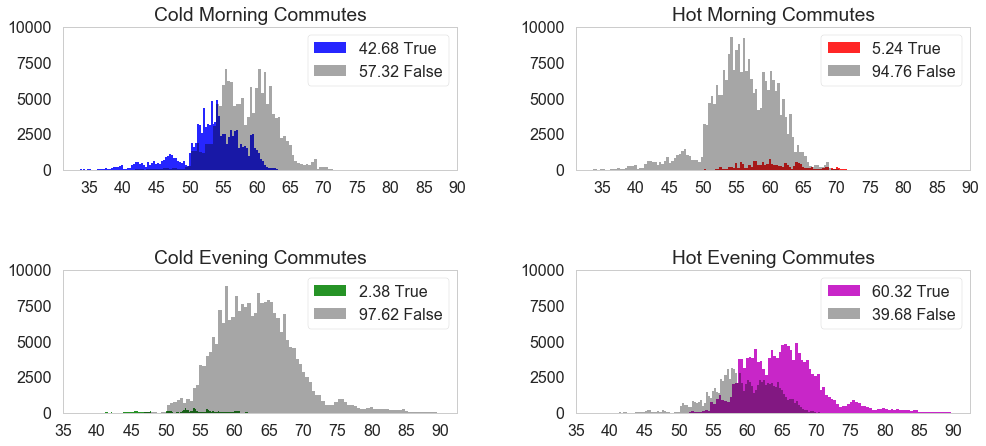

../charts/statistical_analysis/1dev_all_stations_hot_and_cold_commutes.png


In [20]:
plot_hot_cold_histograms(morning_commutes=morning_commutes, 
                                evening_commutes=evening_commutes,
                                bins=100, 
                                y_ticks = [y for y in range(0, 12500, 2500)], 
                                x_ticks = [x for x in range(35, 95, 5)], 
                                has_grid = False, 
                                legend_loc = 1, 
                                frameon=True,
                                file_prefix='1dev_all_stations',
                                write=False)

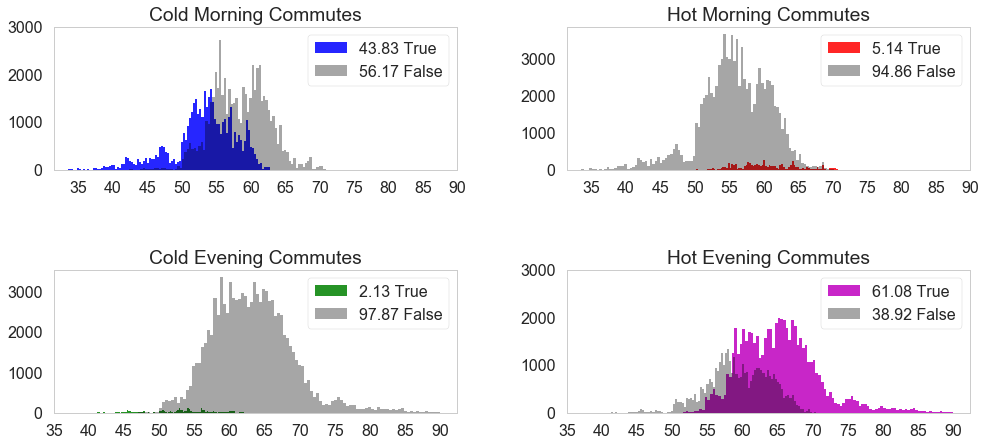

../charts/statistical_analysis/1dev_superstation_hot_and_cold_commutes.png


In [21]:
plot_hot_cold_histograms(morning_commutes=ss_morning_commutes, 
                                evening_commutes=ss_evening_commutes,
                                bins=100, 
                                y_ticks = [y for y in range(0, 4000, 1000)], 
                                x_ticks = [x for x in range(35, 95, 5)], 
                                has_grid = False, 
                                legend_loc = 1, 
                                frameon=True,
                                file_prefix='1dev_superstation',
                                write=False)

# RankSum and Two Sample T Tests

In [22]:
from scipy.stats import ranksums
from scipy.stats import ttest_ind

In [23]:
def ranksums_test(dfA, dfB, a_label='', b_label='', interval_label='dates'):
    
    if dfA.shape[0] > 0:
        A_mean = dfA.mean()
    else:
        A_mean = 0

    if dfB.shape[0] > 0:
        B_mean = dfB.mean()
    else:
        B_mean = 0

    diff_of_means = A_mean - B_mean
    
    if A_mean > 0 or B_mean > 0:
        # perform ranksums test
        z, z_p = ranksums(dfA, dfB)
        t, t_p = ttest_ind(dfA, dfB)
        drop_share = diff_of_means / A_mean * 100.
        
    else:
        z, z_p = [0, 0]
        t, t_p = [0, 0]
        drop_share = 0


    z_can_reject = False
    t_can_reject = False

    if z_p <= 0.05:
        z_can_reject = True
    if t_p <= 0.05:
        t_can_reject = True
        
    results = {'z_score':z, 
                'z_p_value':z_p,
                't_score':t, 
                't_p_value':t_p,
                '{}_{}'.format(a_label.lower(), interval_label):dfA.shape[0], 
                '{}_{}'.format(b_label.lower(), interval_label):dfB.shape[0], 
                '{}_mean'.format(a_label.lower()):A_mean, 
                '{}_mean'.format(b_label.lower()):B_mean, 
                'diff_of_means':diff_of_means, 
                'drop_share':drop_share,
                'z_can_reject':z_can_reject,
                't_can_reject':t_can_reject}
    
    return results
    

# Plot P Values of Z and T Tests

In [24]:
def plot_p_values(df=None, c1=sub_color, c2=sub_color_alt, title='Rainy Morning Commute P-Value', legend_loc=1, hour_range=[7, 10]):

    alpha=0.35
    plt.subplots(figsize=FIG_SIZE)
    ax = sns.barplot(x=df.index, y=df.z_p_value, color=c1, alpha=alpha, label='Wilcoxon Rank-Sum Statistic')

    sns.barplot(x=df.index, y=df.t_p_value, color=c2, alpha=alpha, ax=ax, label='Two Sample T Test')

    ax.axhline(y=0.05, linestyle='-.', alpha=1.0, color='k', linewidth=3)


    x_tick_interval = df.shape[0]/len(day_labels[:5])    
    for x in np.arange(0, x_tick_interval+1):
        ax.axvline(x=x*x_tick_interval+x_tick_interval*(5/6), linestyle=':', alpha=0.5, color='k', linewidth=3)

    x_tick_labels = []
    for x in range(0, df.shape[0]+1, 1):
        label = '{} {}:00'.format(day_labels[int(x/3)], math.floor(x/3)+hour_range[0])
        x_tick_labels.append(label)
        
    # print(x_ticks)
    ax.set_xticks([x-0.5 for x in range(0, df.shape[0], 1)])
    ax.set_xticklabels(x_tick_labels, rotation=45)
    
    ax.set_ylabel('p value')
    ax.set_ylim([0, 0.2])

    ax.legend(loc=legend_loc, frameon=True)

    ax.set_title(title, size=TITLE_FONT_SIZE)
    plt.show()
#     save_path = '../charts/statistical_analysis/{}.png'.format(title.lower().replace(' ', '_').replace('-', ''))
    print(save_path)
#     plt.savefig(save_path)
    plt.close()

# Impact of Cold on Morning Commuter Traffic


<div class="alert alert-info">

<p><b>1a. Morning Cold Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

(479,)
(572,)


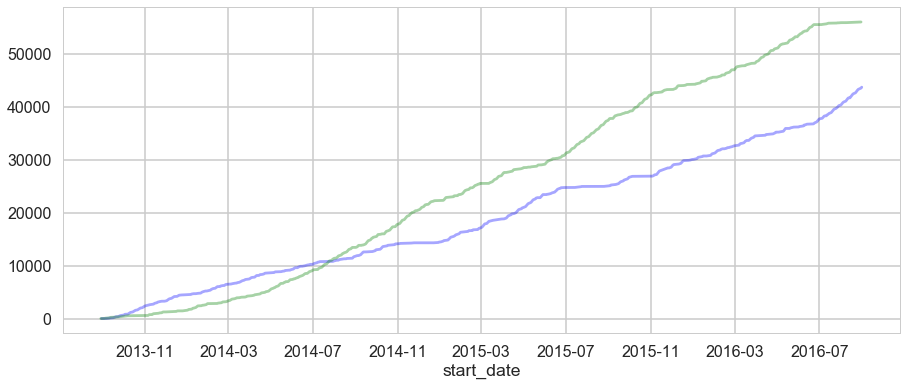

{'cold_dates': 479,
 'cold_mean': 91.365344467640924,
 'diff_of_means': -6.7010890987926359,
 'drop_share': -7.3343882604918935,
 'normal_dates': 572,
 'normal_mean': 98.06643356643356,
 't_can_reject': False,
 't_p_value': 0.051061533749939041,
 't_score': -1.9531994983440766,
 'z_can_reject': True,
 'z_p_value': 0.029267120926640598,
 'z_score': -2.1798697079791931}

In [25]:
# Morning Commutes
COLD = ss_morning_commutes[ss_morning_commutes.is_cold == True].copy()
COLD = COLD.groupby(COLD.start_date.dt.date)['trip_id'].count()
print(COLD.shape)

NORM = ss_morning_commutes[ss_morning_commutes.is_cold == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
COLD.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(COLD, NORM, a_label='Cold', b_label='Normal')

In [26]:
chunks = []

for month in sorted(ss_morning_commutes.start_date.dt.month.unique()):
    month_data = ss_morning_commutes[ss_morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    COLD = month_data[month_data.is_cold == True].copy()
    COLD = COLD.groupby(COLD.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_cold == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(COLD, NORM, a_label='Cold', b_label='Normal', interval_label='dates')
    chunks.append(R)

morning_cold_commute_t_test = pd.DataFrame(chunks)
morning_cold_commute_t_test.fillna(0, inplace=True)
# morning_cold_commute_t_test[(morning_cold_commute_t_test.z_can_reject == True) | (morning_cold_commute_t_test.t_can_reject == True)]

morning_cold_commute_t_test



,cold_dates,cold_mean,diff_of_means,drop_share,normal_dates,normal_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,38,97.000000,20.632653,21.270776,49,76.367347,False,0.059965,1.906498,False,0.071639,1.801406
1,43,81.604651,-9.258985,-11.346149,44,90.863636,False,0.414928,-0.819262,False,0.280952,-1.078183
2,47,97.936170,9.180615,9.374080,45,88.755556,False,0.405761,0.835300,False,0.486956,0.695159
3,41,97.780488,-10.545599,-10.784973,46,108.326087,False,0.356950,-0.926227,False,0.309571,-1.016123
4,45,89.755556,-8.264052,-9.207288,51,98.019608,False,0.510839,-0.660046,False,0.702622,-0.381783
5,44,86.136364,-19.900000,-23.102902,55,106.036364,False,0.073030,-1.812326,False,0.091698,-1.686508
6,35,98.400000,-15.031373,-15.275785,51,113.431373,False,0.205661,-1.275465,False,0.237080,-1.182318
7,39,110.820513,-11.868376,-10.709548,45,122.688889,False,0.344412,-0.950975,False,0.907180,-0.116597
8,40,90.250000,11.209184,12.420148,49,79.040816,False,0.379683,0.882974,False,0.294879,1.047478
9,33,91.848485,-31.513217,-34.310002,47,123.361702,True,0.004289,-2.942252,True,0.001595,-3.156783


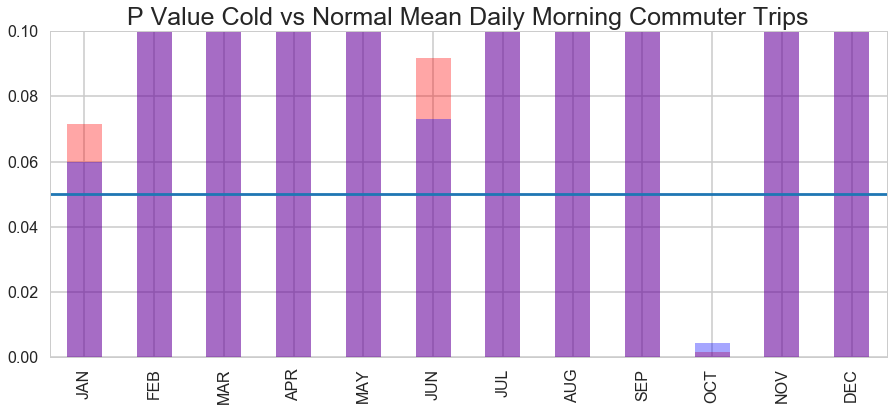

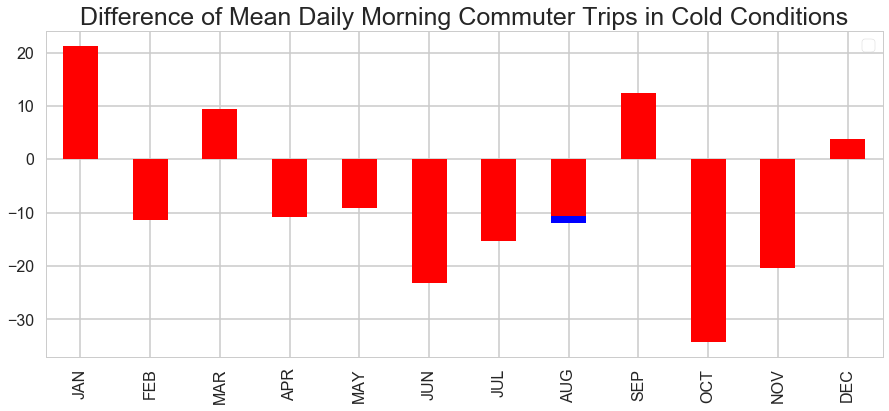

In [27]:
ax = morning_cold_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
morning_cold_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'P Value Cold vs Normal Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = morning_cold_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
morning_cold_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Morning Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()

# save_path = '../charts/statistical_analysis/morning_commute_cold.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

# Impact of Heat on Morning Commuter Traffic

<div class="alert alert-info">

<p><b>1a. Morning Hot Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Hot Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Hot Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

(38,)
(765,)


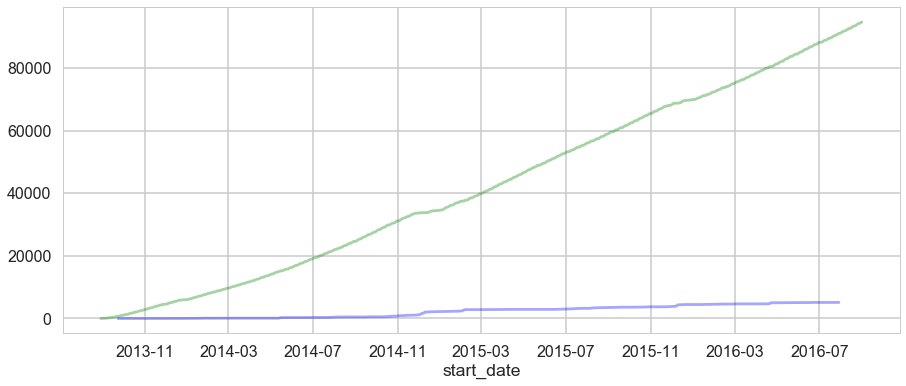

{'diff_of_means': -61.266475370636059,
 'drop_share': -97.930818331231123,
 'hot_dates': 82,
 'hot_mean': 62.560975609756099,
 'normal_dates': 765,
 'normal_mean': 123.82745098039216,
 't_can_reject': True,
 't_p_value': 3.8406934494610595e-28,
 't_score': -11.408862439249976,
 'z_can_reject': True,
 'z_p_value': 6.3368613573626957e-17,
 'z_score': -8.3587828775094017}

In [28]:
# Morning Commutes
HOT = ss_morning_commutes[ss_morning_commutes.is_hot == True].copy()
HOT = HOT.groupby(HOT.start_date.dt.date)['trip_id'].count()
print(COLD.shape)

NORM = ss_morning_commutes[ss_morning_commutes.is_hot == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
HOT.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(HOT, NORM, a_label='Hot', b_label='Normal')

In [29]:
chunks = []

for month in sorted(ss_morning_commutes.start_date.dt.month.unique()):
    month_data = ss_morning_commutes[ss_morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    HOT = month_data[month_data.is_hot == True].copy()
    HOT = HOT.groupby(HOT.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_hot == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(HOT, NORM, a_label='Hot', b_label='Normal', interval_label='dates')
    chunks.append(R)

morning_hot_commute_t_test = pd.DataFrame(chunks)
morning_hot_commute_t_test.fillna(0, inplace=True)
# morning_hot_commute_t_test[(morning_hot_commute_t_test.z_can_reject == True) | (morning_hot_commute_t_test.t_can_reject == True)]

morning_hot_commute_t_test




,diff_of_means,drop_share,hot_dates,hot_mean,normal_dates,normal_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,-69.271875,-159.612615,5,43.400000,64,112.671875,True,1.312487e-03,-3.354401,True,0.014150,-2.453423
1,-19.527845,-20.281145,7,96.285714,59,115.813559,False,2.967475e-01,-1.052017,False,0.532142,-0.624740
2,-102.378788,-383.920455,3,26.666667,66,129.045455,True,1.176936e-06,-5.343758,True,0.003579,-2.913025
3,-67.218750,-100.326493,6,67.000000,64,134.218750,True,3.093805e-05,-4.465225,True,0.012540,-2.496565
4,-72.700000,-116.320000,4,62.500000,65,135.200000,True,1.787283e-03,-3.253570,True,0.008174,-2.644796
5,-128.022727,-764.314790,4,16.750000,66,144.772727,True,6.247501e-13,-8.851984,True,0.001099,-3.263993
6,-69.381250,-99.972983,5,69.400000,64,138.781250,True,5.426574e-05,-4.312469,False,0.091100,-1.689622
7,-78.258403,-129.812517,7,60.285714,68,138.544118,True,3.775352e-05,-4.388978,True,0.001482,-3.178160
8,-81.921875,-256.005859,6,32.000000,64,113.921875,True,8.050773e-04,-3.508043,True,0.001234,-3.230848
9,-83.756219,-197.849336,9,42.333333,67,126.089552,True,4.237518e-08,-6.111077,True,0.000036,-4.131614


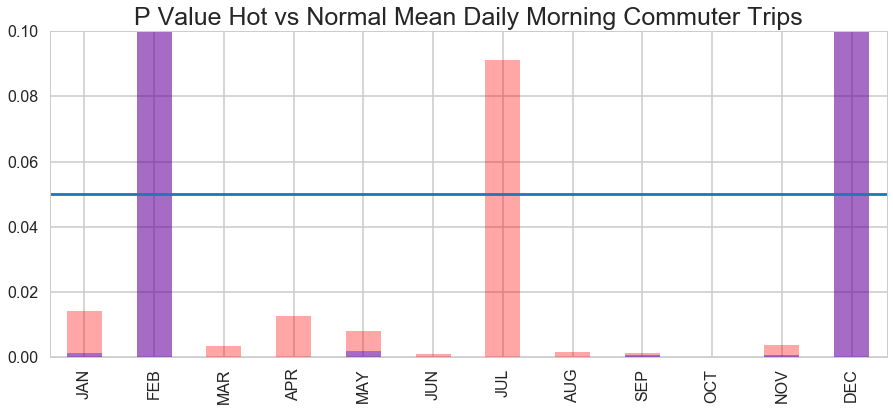

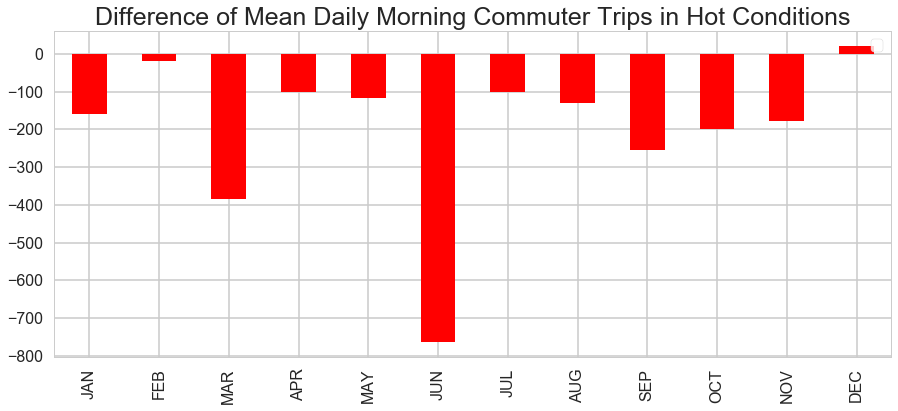

In [30]:
ax = morning_hot_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
morning_hot_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'P Value Hot vs Normal Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = morning_hot_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
morning_hot_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Morning Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

# Impact of Cold on Evening Commuter Traffic


<div class="alert alert-info">

<p><b>2a. Evening Cold Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Cold Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Cold Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

(53,)
(774,)


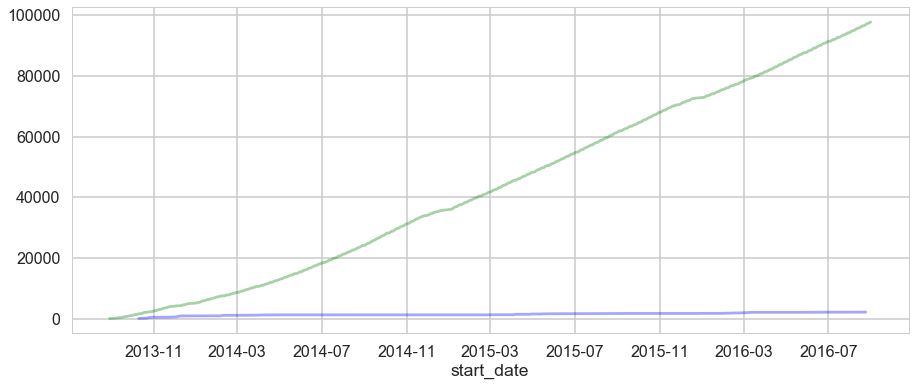

{'cold_dates': 53,
 'cold_mean': 40.188679245283019,
 'diff_of_means': -86.1679099020038,
 'drop_share': -214.40841431015031,
 'normal_dates': 774,
 'normal_mean': 126.35658914728683,
 't_can_reject': True,
 't_p_value': 1.8706622901275443e-37,
 't_score': -13.455133202677416,
 'z_can_reject': True,
 'z_p_value': 7.8412384057034356e-24,
 'z_score': -10.065594206843659}

In [31]:
# Morning Commutes
COLD = ss_evening_commutes[ss_evening_commutes.is_cold == True].copy()
COLD = COLD.groupby(COLD.start_date.dt.date)['trip_id'].count()
print(COLD.shape)

NORM = ss_evening_commutes[ss_evening_commutes.is_cold == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
COLD.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(COLD, NORM, a_label='Cold', b_label='Normal')

In [32]:
chunks = []

for month in sorted(ss_evening_commutes.start_date.dt.month.unique()):
    month_data = ss_evening_commutes[ss_evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    COLD = month_data[month_data.is_cold == True].copy()
    COLD = COLD.groupby(COLD.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_cold == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(COLD, NORM, a_label='Cold', b_label='Normal', interval_label='dates')
    chunks.append(R)

evening_cold_commute_t_test = pd.DataFrame(chunks)
evening_cold_commute_t_test.fillna(0, inplace=True)
# evening_cold_commute_t_test[(evening_cold_commute_t_test.z_can_reject == True) | (evening_cold_commute_t_test.t_can_reject == True)]

evening_cold_commute_t_test



/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


,cold_dates,cold_mean,diff_of_means,drop_share,normal_dates,normal_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,3,1.000000,-117.203125,-1.172031e+04,64,118.203125,True,2.125613e-06,-5.205059,True,0.003609,-2.910428
1,10,36.300000,-83.217241,-2.292486e+02,58,119.517241,True,1.156868e-07,-5.944140,True,0.000020,-4.268438
2,3,87.666667,-45.145833,-5.149715e+01,64,132.812500,True,2.072506e-02,-2.370789,True,0.031358,-2.152504
3,6,37.166667,-95.587179,-2.571852e+02,65,132.753846,True,1.294586e-07,-5.885538,True,0.001013,-3.286920
4,5,37.400000,-96.800000,-2.588235e+02,65,134.200000,True,4.610630e-06,-4.979906,True,0.000906,-3.318049
5,1,44.000000,-103.606061,-2.354683e+02,66,147.606061,False,0.000000e+00,0.000000,False,0.097989,-1.654681
6,0,0.000000,-138.552239,-inf,67,138.552239,False,0.000000e+00,0.000000,False,0.000000,0.000000
7,5,7.200000,-142.352239,-1.977114e+03,67,149.552239,True,3.644285e-15,-10.022186,True,0.000257,-3.655028
8,2,55.000000,-61.723077,-1.122238e+02,65,116.723077,False,1.518952e-01,-1.449898,False,0.161494,-1.400065
9,8,54.000000,-70.147059,-1.299020e+02,68,124.147059,True,3.423231e-04,-3.755447,True,0.000855,-3.334357


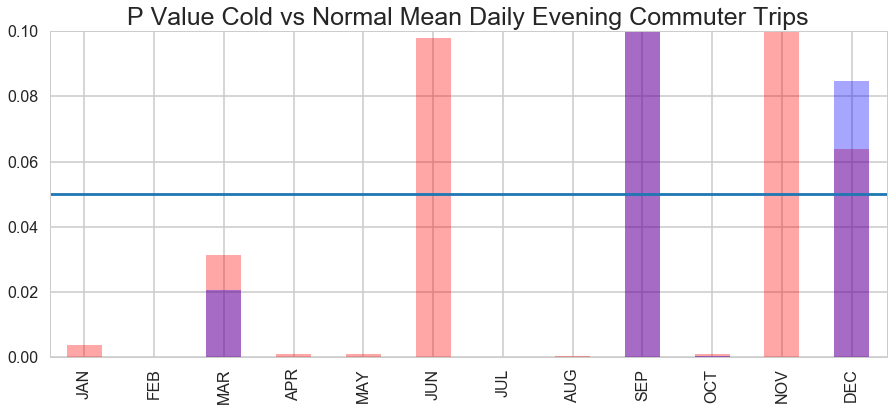

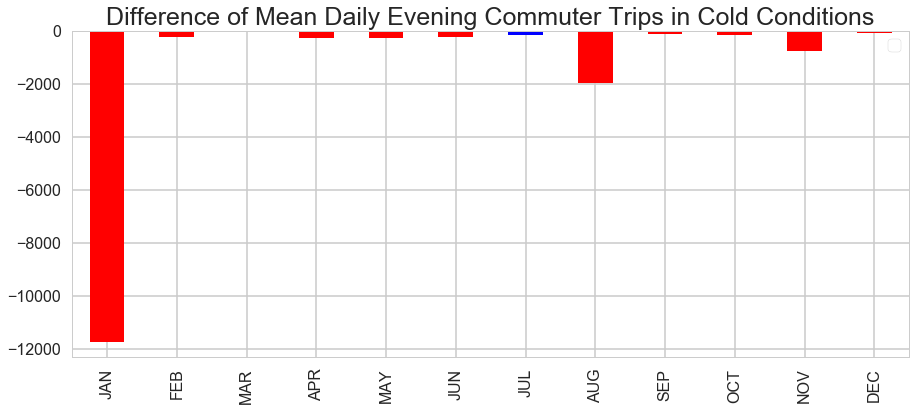

In [33]:
ax = evening_cold_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
evening_cold_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'P Value Cold vs Normal Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = evening_cold_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
evening_cold_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Evening Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

# Impact of Heat on Evening Commuter Traffic


<div class="alert alert-info">

<p><b>2b. Evening Hot Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Cold Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Cold Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

(586,)
(470,)


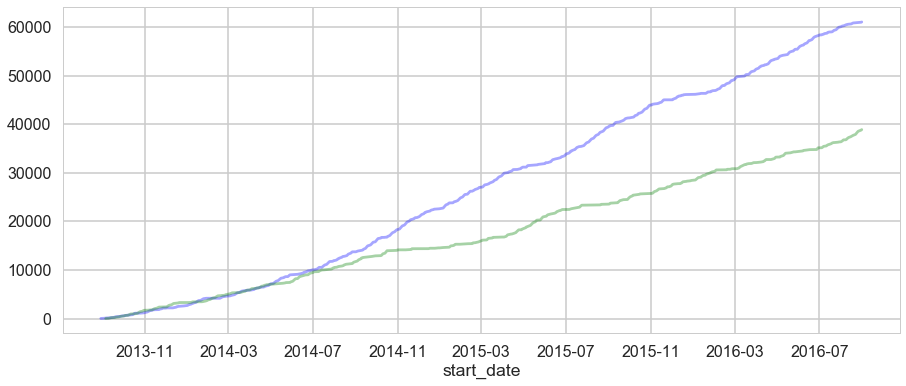

{'cold_dates': 9,
 'cold_mean': 50.555555555555557,
 'diff_of_means': -32.184869976359337,
 'drop_share': -63.662380173018462,
 'normal_dates': 470,
 'normal_mean': 82.740425531914894,
 't_can_reject': False,
 't_p_value': 0.083484190388754972,
 't_score': -1.7344505056790323,
 'z_can_reject': False,
 'z_p_value': 0.073766055943294578,
 'z_score': -1.7880616874450241}

In [34]:
# Morning Commutes
HOT = ss_evening_commutes[ss_evening_commutes.is_hot == True].copy()
HOT = HOT.groupby(HOT.start_date.dt.date)['trip_id'].count()
print(HOT.shape)

NORM = ss_evening_commutes[ss_evening_commutes.is_hot == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
HOT.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(COLD, NORM, a_label='Cold', b_label='Normal')

In [35]:
chunks = []

for month in sorted(ss_evening_commutes.start_date.dt.month.unique()):
    month_data = ss_evening_commutes[ss_evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    HOT = month_data[month_data.is_hot == True].copy()
    HOT = HOT.groupby(HOT.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_hot == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(HOT, NORM, a_label='Hot', b_label='Normal', interval_label='dates')
    chunks.append(R)

evening_hot_commute_t_test = pd.DataFrame(chunks)
evening_hot_commute_t_test.fillna(0, inplace=True)
# evening_hot_commute_t_test[(evening_hot_commute_t_test.z_can_reject == True) | (evening_hot_commute_t_test.t_can_reject == True)]

evening_hot_commute_t_test


,diff_of_means,drop_share,hot_dates,hot_mean,normal_dates,normal_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,21.372081,22.272457,47,95.957447,41,74.585366,True,0.044735,2.036906,False,0.061549,1.869529
1,42.511111,39.016928,45,108.955556,36,66.444444,True,0.000388,3.707031,True,0.000453,3.507136
2,34.576923,31.118034,52,111.115385,39,76.538462,True,0.002130,3.163989,True,0.002851,2.983360
3,18.574317,17.129483,46,108.434783,43,89.860465,False,0.105936,1.633700,False,0.115890,1.572262
4,3.407275,3.089684,43,110.279070,39,106.871795,False,0.791843,0.264802,False,0.933402,-0.083566
5,15.742690,12.582967,45,125.111111,38,109.368421,False,0.210084,1.263360,False,0.163356,1.393872
6,36.054723,34.270303,58,105.206897,46,69.152174,True,0.001351,3.295677,True,0.002339,3.043379
7,12.146387,10.843228,55,112.018182,39,99.871795,False,0.292783,1.058094,False,0.235774,1.185615
8,14.095897,15.212495,50,92.660000,39,78.564103,False,0.283480,1.079202,False,0.360863,0.913723
9,22.232993,19.534098,49,113.816327,36,91.583333,False,0.075669,1.798904,False,0.067595,1.827696


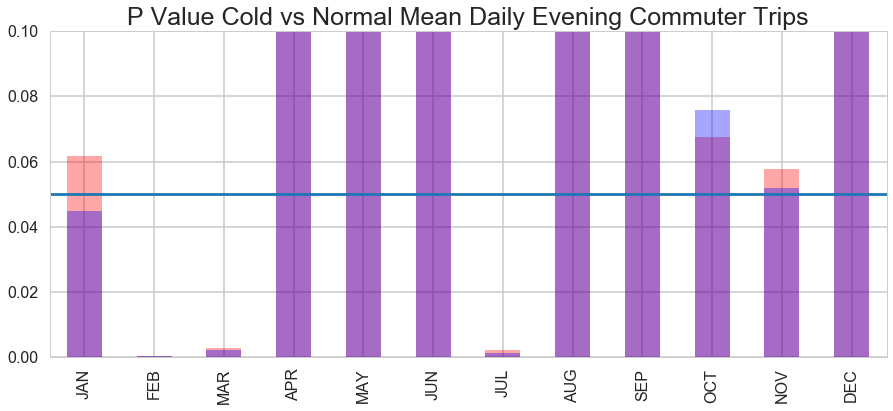

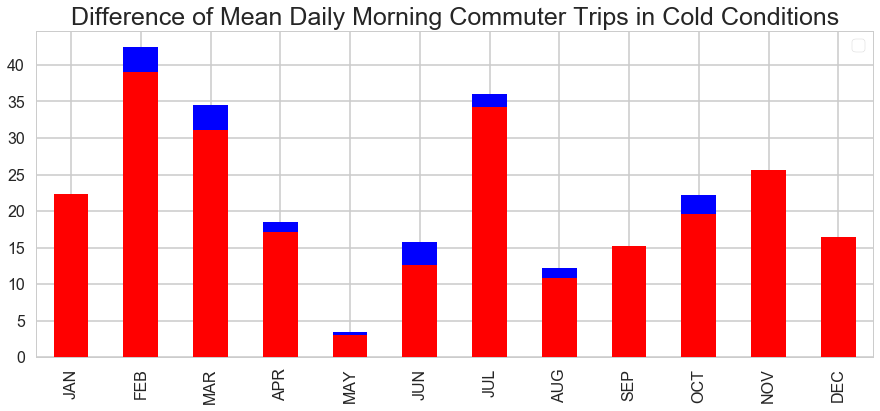

In [36]:
ax = evening_hot_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
evening_hot_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'P Value Cold vs Normal Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = evening_hot_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
evening_hot_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Morning Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

# RAIN

In [37]:
def plot_rain_histograms(morning_commutes=morning_commutes, 
                                evening_commutes=evening_commutes,
                                bins=100, 
                                y_ticks = [y for y in range(0, 15*61)], 
                                x_ticks = [x for x in range(0, 15*61)], 
                                has_grid = False, 
                                legend_loc = 1, 
                                frameon=True,
                                title_prefix='',
                                file_prefix='all_stations_',
                                write=False):

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(GRID_DIMS, GRID_DIMS*0.5))

    # 15 minute ride in seconds
    duration_cutoff = 15*60

    morning_commutes[(morning_commutes.is_rainy_day == True) & (morning_commutes.duration <= duration_cutoff)].duration.hist(ax=axes[0], bins=bins, color='b', alpha=0.85)
    morning_commutes[(morning_commutes.is_rainy_day == False) & (morning_commutes.duration <= duration_cutoff)].duration.hist(ax=axes[0], bins=bins, color='k', alpha=0.35)
#     axes[0].set_yticks(y_ticks)
    axes[0].set_xticks(x_ticks)
    axes[0].set_title('{} Rainy Morning Commutes'.format(title_prefix.title()))
    axes[0].legend(['{:2.2f}% Rainy Trips'.format(morning_commutes[morning_commutes.is_rainy_day == True].shape[0]/morning_commutes.shape[0]*100), 
                      '{:2.2f}% Dry Trips'.format(morning_commutes[morning_commutes.is_rainy_day == False].shape[0]/morning_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[0].grid(has_grid)

    evening_commutes[(evening_commutes.is_rainy_day == True) & (evening_commutes.duration <= duration_cutoff)].duration.hist(ax=axes[1], bins=bins, color='g', alpha=0.85)
    evening_commutes[(evening_commutes.is_rainy_day == False) & (evening_commutes.duration <= duration_cutoff)].duration.hist(ax=axes[1], bins=bins, color='k', alpha=0.35)
#     axes[1].set_yticks(y_ticks)
    axes[1].set_xticks(x_ticks)
    axes[1].set_title('{} Rainy Evening Commutes'.format(title_prefix.title()))
    axes[1].legend(['{:2.2f}% Rainy Trips'.format(evening_commutes[evening_commutes.is_rainy_day == True].shape[0]/evening_commutes.shape[0]*100), 
                      '{:2.2f}% Dry Trips'.format(evening_commutes[evening_commutes.is_rainy_day == False].shape[0]/evening_commutes.shape[0]*100)], loc=legend_loc, frameon=frameon)
    axes[1].grid(has_grid)


    plt.tight_layout()
    file_name = '../charts/statistical_analysis/rain_{} {} {}_commutes.png'.format(str(month_labels_full.index(title_prefix)+1).zfill(2), file_prefix, title_prefix.lower()).replace(' ', '_').replace('__', '_')
    
    if write:
        plt.savefig(file_name)
    else:
        plt.show()
    print(file_name)
    plt.close()

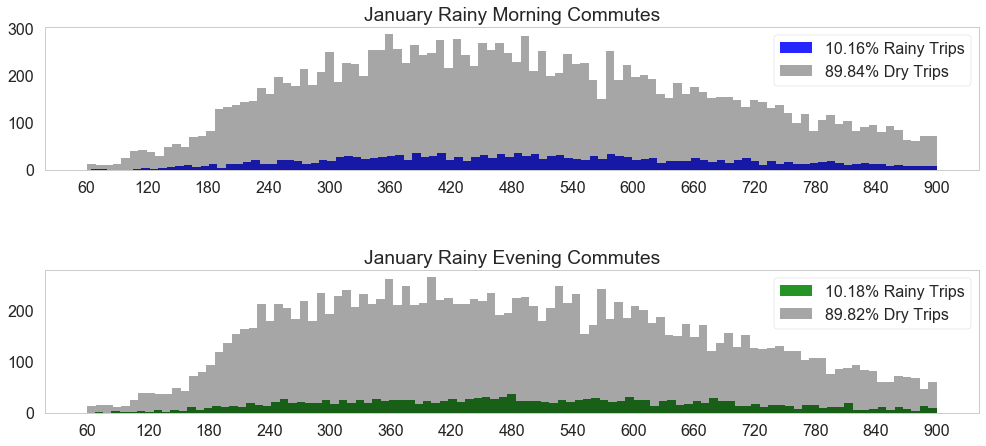

../charts/statistical_analysis/rain_01_all_stations_january_commutes.png


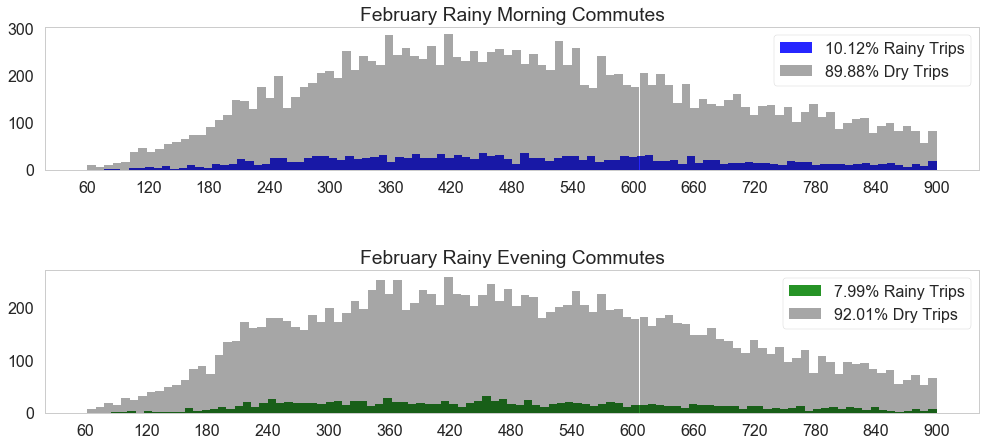

../charts/statistical_analysis/rain_02_all_stations_february_commutes.png


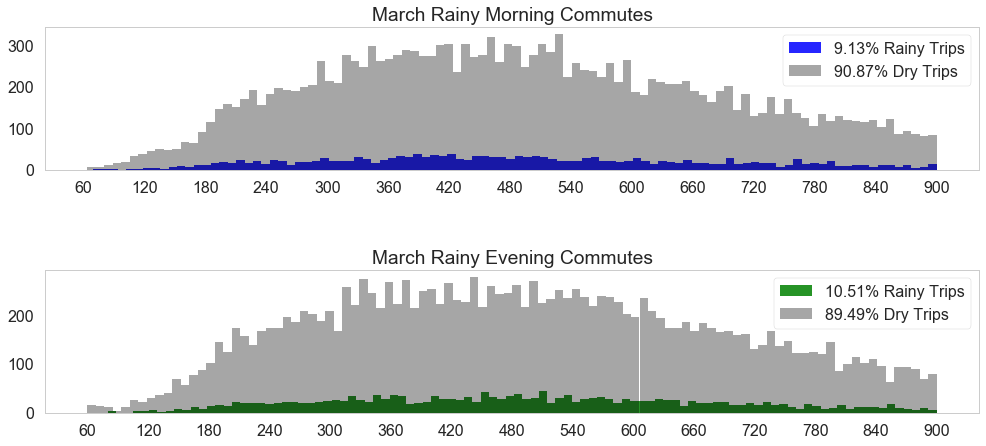

../charts/statistical_analysis/rain_03_all_stations_march_commutes.png


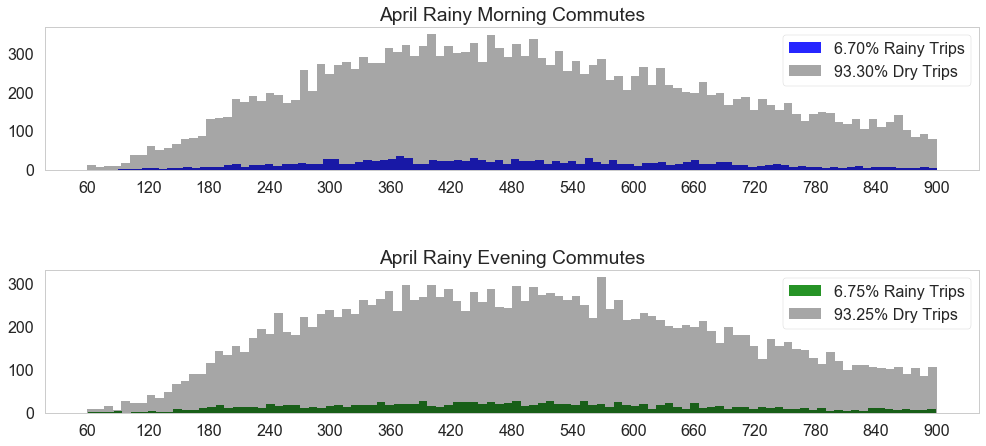

../charts/statistical_analysis/rain_04_all_stations_april_commutes.png


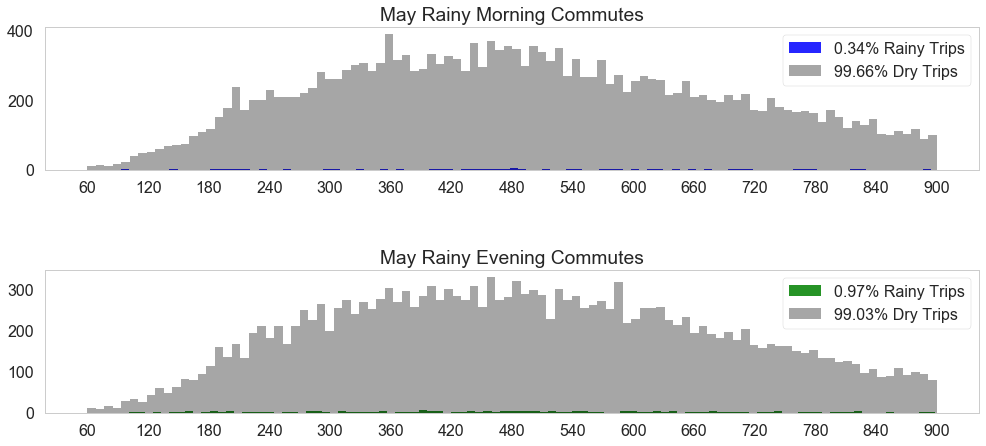

../charts/statistical_analysis/rain_05_all_stations_may_commutes.png


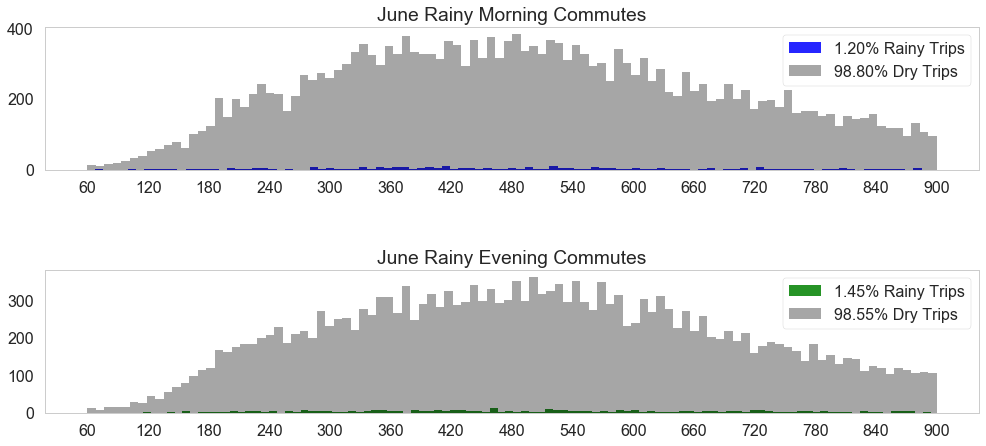

../charts/statistical_analysis/rain_06_all_stations_june_commutes.png


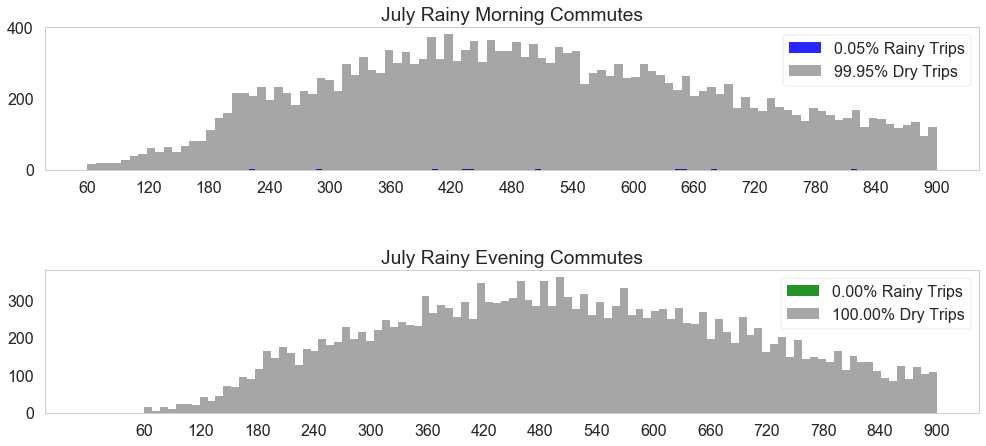

../charts/statistical_analysis/rain_07_all_stations_july_commutes.png


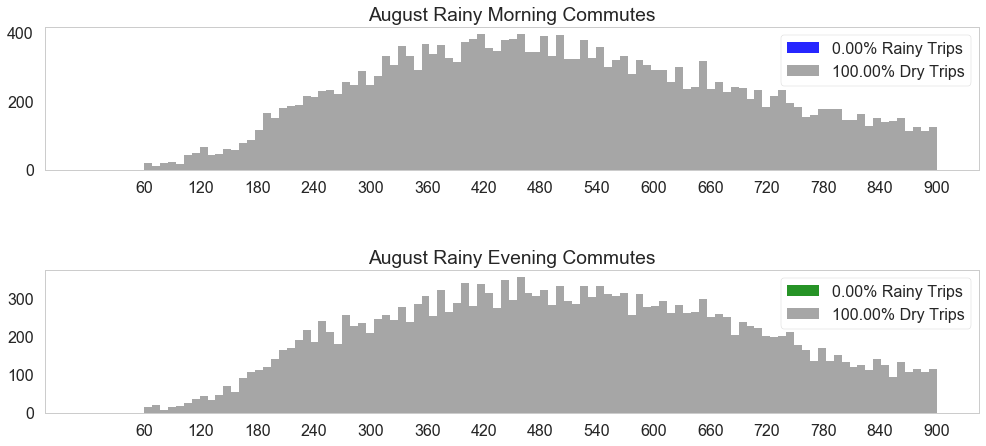

../charts/statistical_analysis/rain_08_all_stations_august_commutes.png


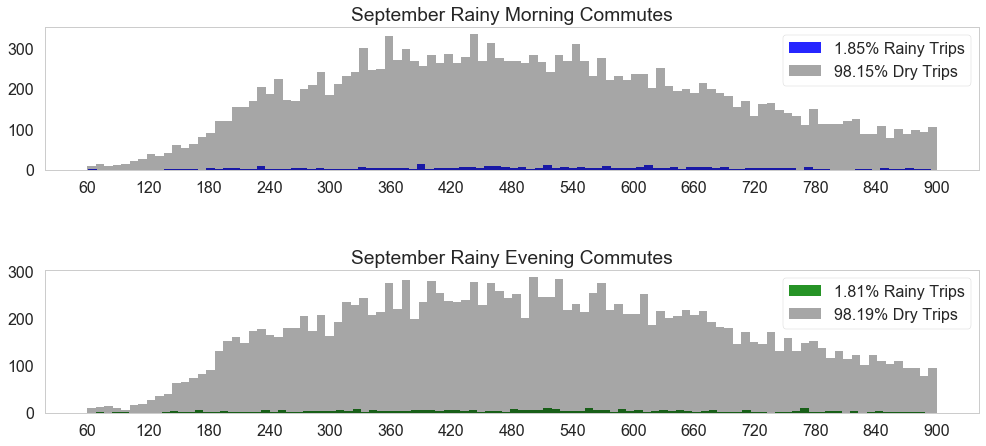

../charts/statistical_analysis/rain_09_all_stations_september_commutes.png


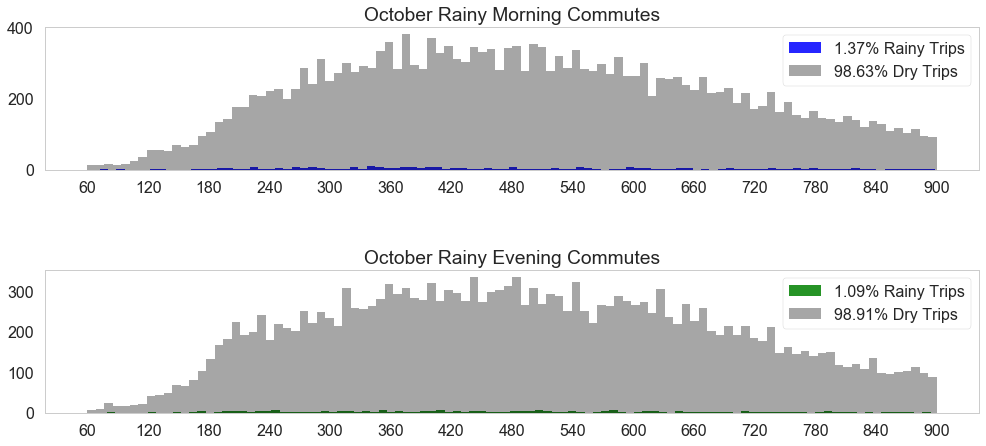

../charts/statistical_analysis/rain_10_all_stations_october_commutes.png


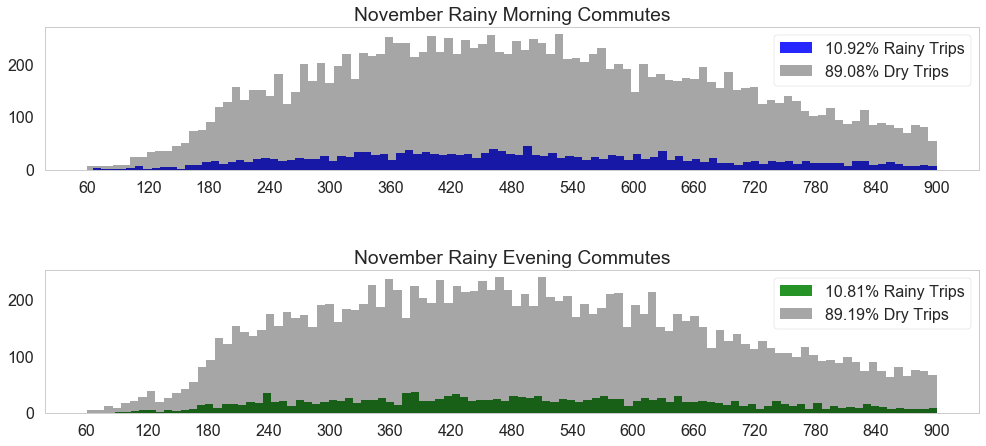

../charts/statistical_analysis/rain_11_all_stations_november_commutes.png


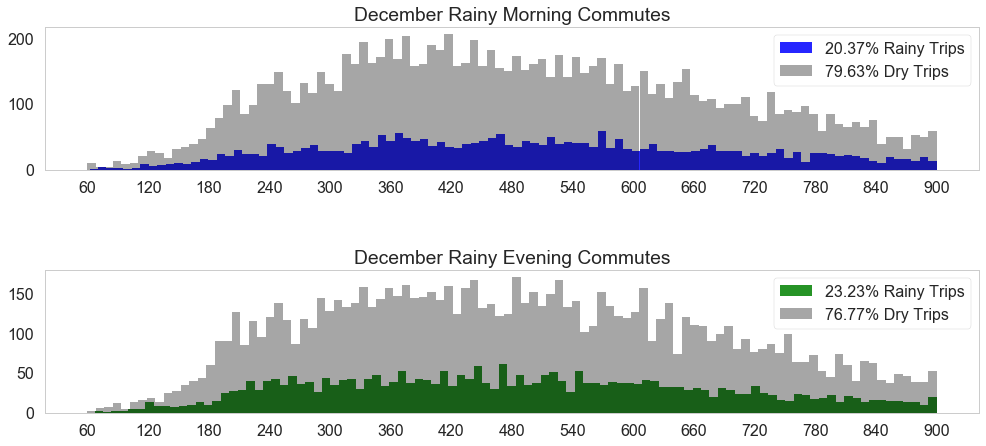

../charts/statistical_analysis/rain_12_all_stations_december_commutes.png


In [38]:
for month in sorted(morning_commutes.start_date.dt.month.unique()):

    plot_rain_histograms(morning_commutes=morning_commutes[morning_commutes.start_date.dt.month == month], 
                                    evening_commutes=evening_commutes[evening_commutes.start_date.dt.month == month],
                                    bins=100, 
                                    y_ticks = [y for y in range(0, 12500, 2500)], 
                                    x_ticks = [x*60 for x in range(1, 16)], 
                                    has_grid = False, 
                                    legend_loc = 1, 
                                    frameon=True,
                                    file_prefix='all_stations',
                                    title_prefix=month_labels_full[month-1],
                                    write=False)

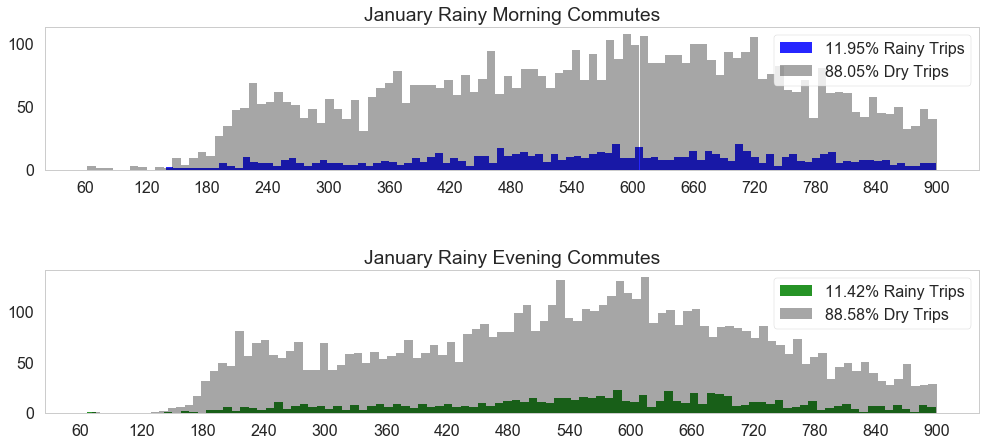

../charts/statistical_analysis/rain_01_super_station_january_commutes.png


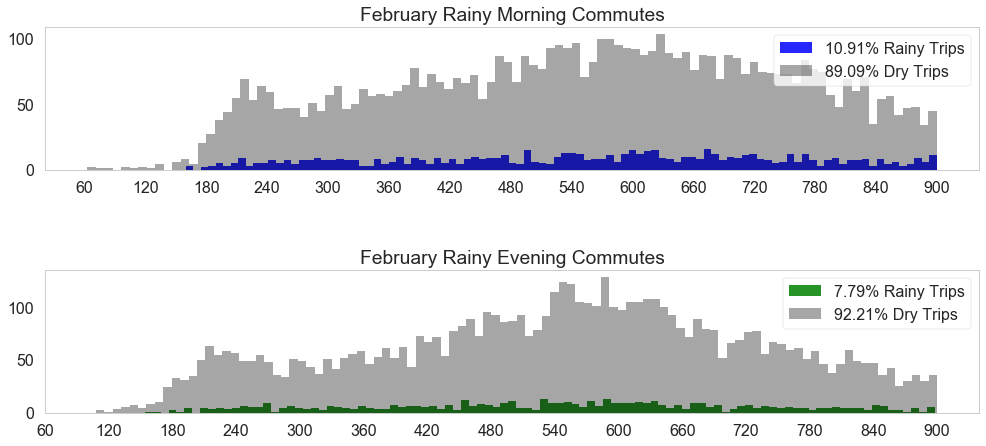

../charts/statistical_analysis/rain_02_super_station_february_commutes.png


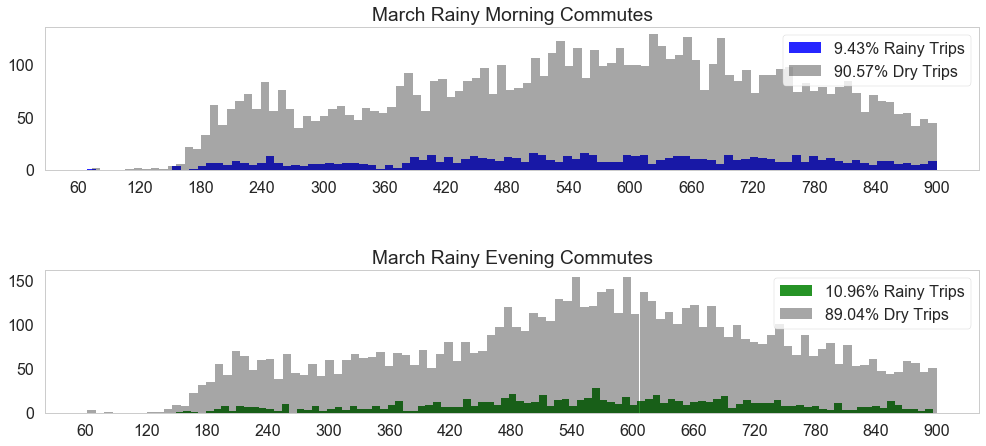

../charts/statistical_analysis/rain_03_super_station_march_commutes.png


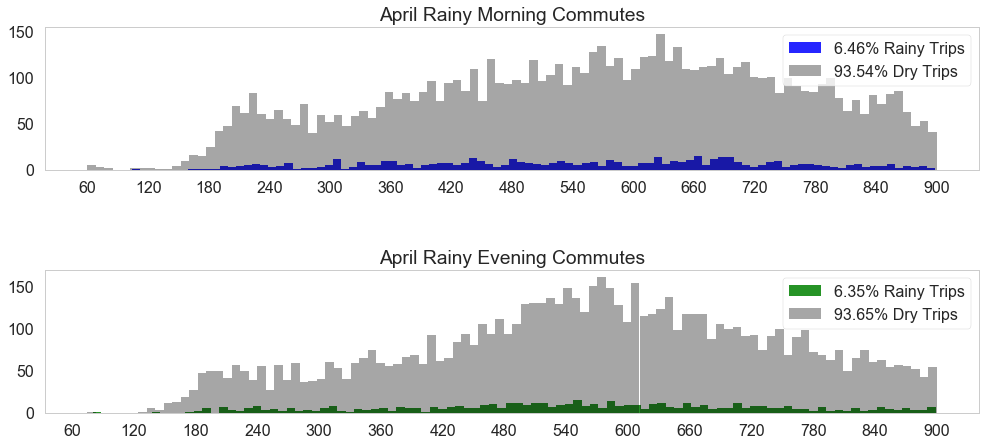

../charts/statistical_analysis/rain_04_super_station_april_commutes.png


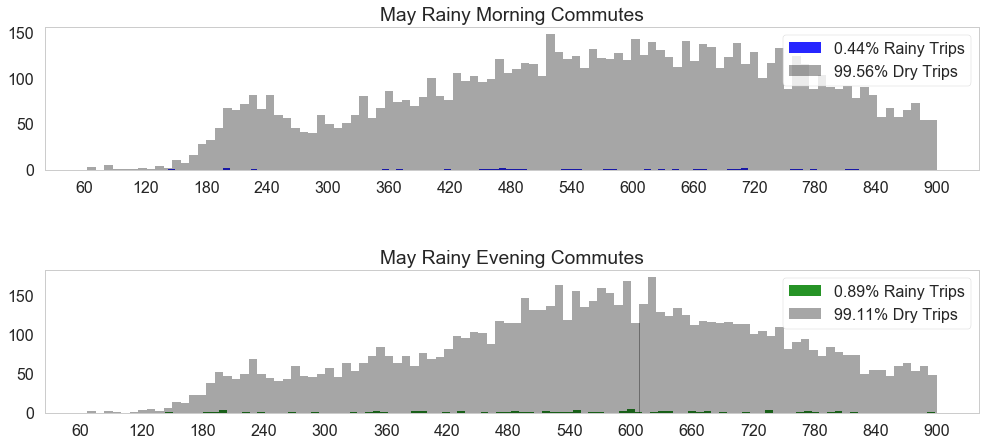

../charts/statistical_analysis/rain_05_super_station_may_commutes.png


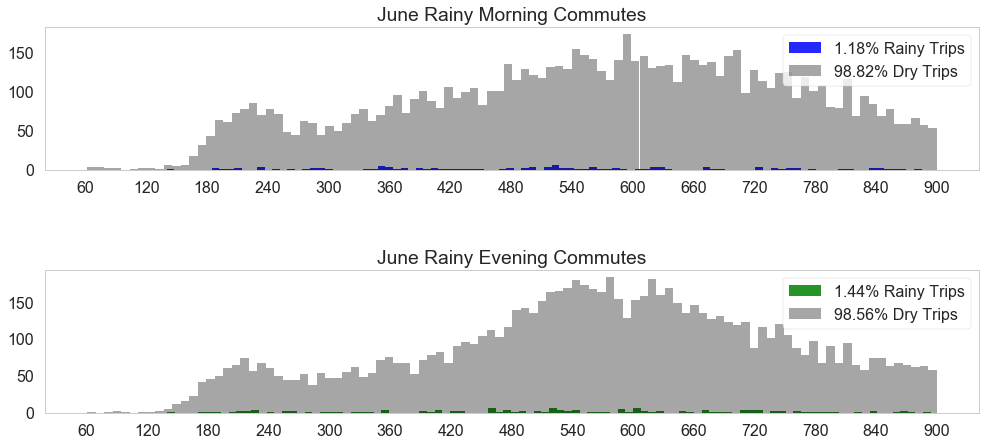

../charts/statistical_analysis/rain_06_super_station_june_commutes.png


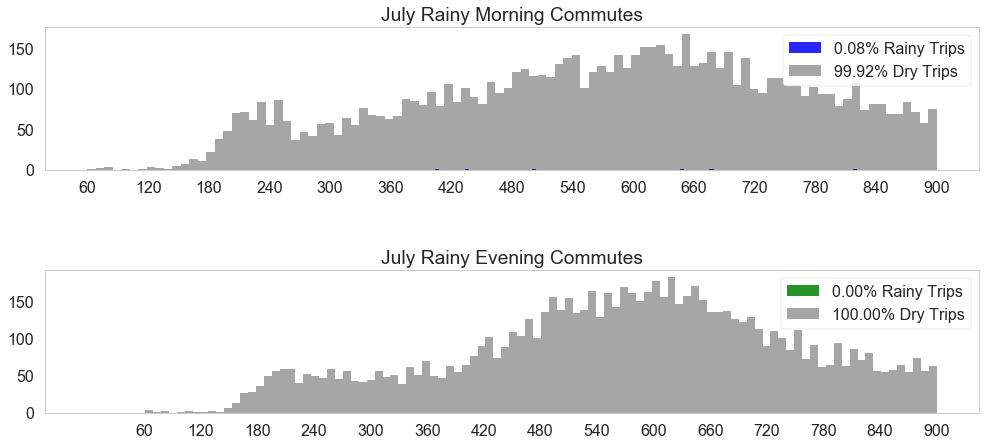

../charts/statistical_analysis/rain_07_super_station_july_commutes.png


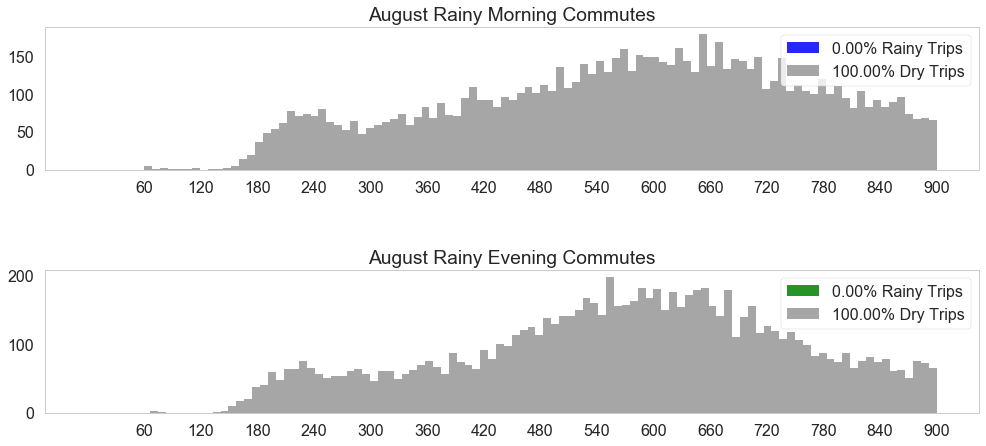

../charts/statistical_analysis/rain_08_super_station_august_commutes.png


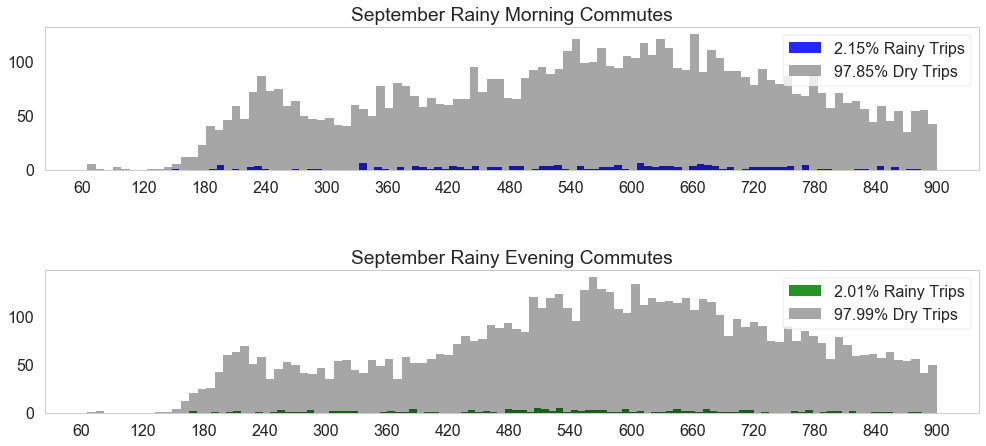

../charts/statistical_analysis/rain_09_super_station_september_commutes.png


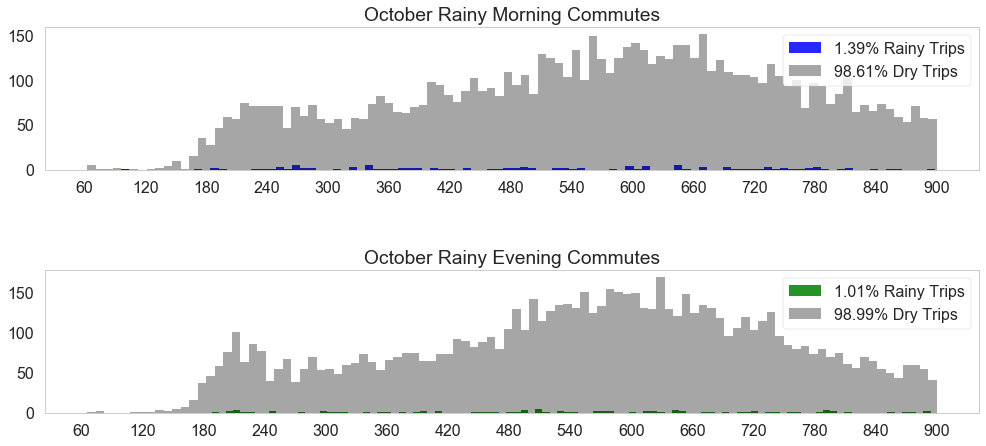

../charts/statistical_analysis/rain_10_super_station_october_commutes.png


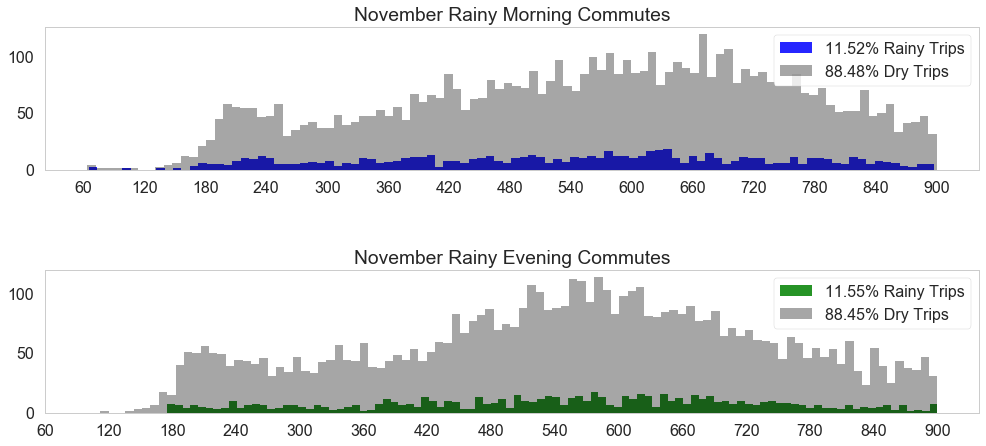

../charts/statistical_analysis/rain_11_super_station_november_commutes.png


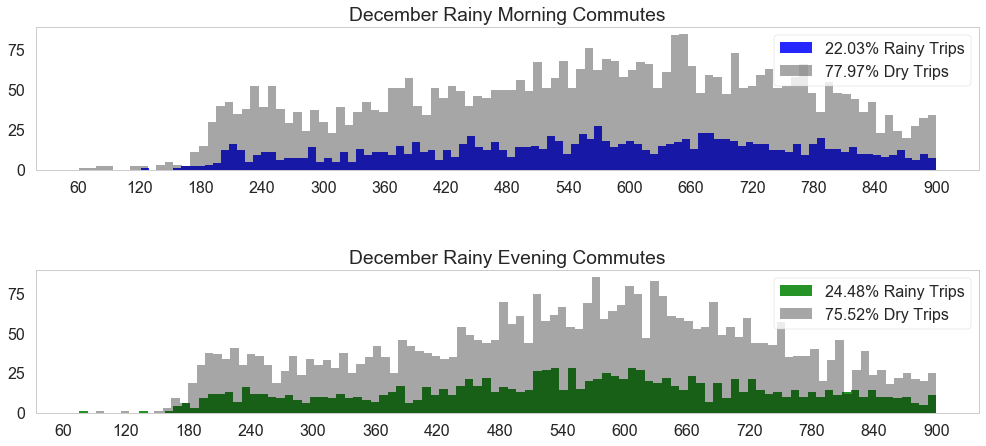

../charts/statistical_analysis/rain_12_super_station_december_commutes.png


In [40]:
for month in sorted(ss_morning_commutes.start_date.dt.month.unique()):

    plot_rain_histograms(morning_commutes=ss_morning_commutes[ss_morning_commutes.start_date.dt.month == month], 
                                    evening_commutes=ss_evening_commutes[ss_evening_commutes.start_date.dt.month == month],
                                    bins=100, 
                                    y_ticks = [y for y in range(0, 12500, 2500)], 
                                    x_ticks = [x*60 for x in range(1, 16)], 
                                    has_grid = False, 
                                    legend_loc = 1, 
                                    frameon=True,
                                    file_prefix='super_station',
                                    title_prefix=month_labels_full[month-1],
                                    write=False)

# Impact of Rain on Morning Commuter Traffic


<div class="alert alert-info">

<p><b>31. Morning Rainy Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

(81,)
(735,)


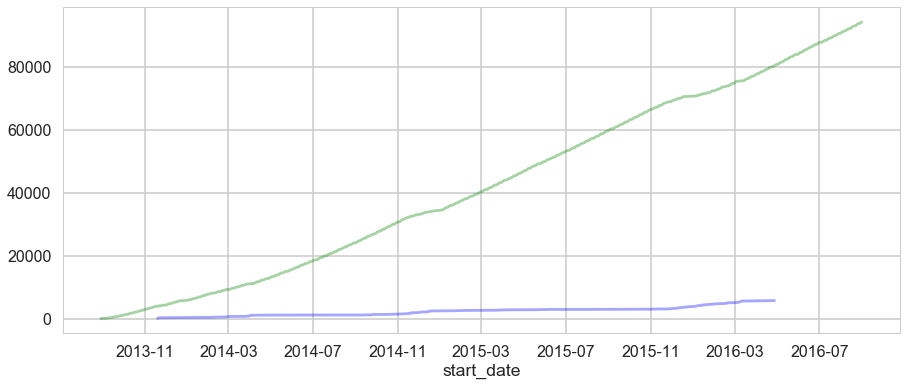

{'diff_of_means': -57.598689846308901,
 'drop_share': -81.707423424711408,
 'normal_dates': 735,
 'normal_mean': 128.09251700680272,
 'rain_dates': 81,
 'rain_mean': 70.493827160493822,
 't_can_reject': True,
 't_p_value': 7.4249065491549182e-27,
 't_score': -11.123549047654294,
 'z_can_reject': True,
 'z_p_value': 3.8526346979723747e-22,
 'z_score': -9.6749543707162822}

In [42]:
# Morning Commutes
RAINY = ss_morning_commutes[ss_morning_commutes.is_rainy_day == True].copy()
RAINY = RAINY.groupby(RAINY.start_date.dt.date)['trip_id'].count()
print(RAINY.shape)

NORM = ss_morning_commutes[ss_morning_commutes.is_rainy_day == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
RAINY.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(RAINY, NORM, a_label='Rain', b_label='Normal')

In [43]:
chunks = []

for month in sorted(ss_morning_commutes.start_date.dt.month.unique()):
    month_data = ss_morning_commutes[ss_morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    RAINY = month_data[month_data.is_rainy_day == True].copy()
    RAINY = RAINY.groupby(RAINY.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_rainy_day == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(RAINY, NORM, a_label='Rainy', b_label='Normal', interval_label='dates')
    chunks.append(R)

morning_rain_commute_t_test = pd.DataFrame(chunks)
morning_rain_commute_t_test.fillna(0, inplace=True)
# morning_rain_commute_t_test[(morning_rain_commute_t_test.z_can_reject == True) | (morning_rain_commute_t_test.t_can_reject == True)]

morning_rain_commute_t_test


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


,diff_of_means,drop_share,normal_dates,normal_mean,rainy_dates,rainy_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,-32.031348,-39.678472,58,112.758621,11,80.727273,True,3.290381e-02,-2.178340,True,0.011864,-2.516168
1,-49.397306,-66.345589,54,123.851852,11,74.454545,True,9.492971e-04,-3.468469,True,0.002696,-3.000472
2,-50.866102,-62.720224,59,131.966102,10,81.100000,True,8.443150e-05,-4.186607,True,0.003017,-2.965957
3,-59.559322,-71.758219,59,142.559322,7,83.000000,True,4.191349e-07,-5.636741,True,0.000688,-3.394422
4,-98.430769,-246.076923,65,138.430769,1,40.000000,False,0.000000e+00,0.000000,False,0.121496,-1.548526
5,-89.276923,-156.626181,65,146.276923,2,57.000000,True,3.759187e-05,-4.425275,True,0.020278,-2.321160
6,-136.227273,-3892.207792,66,139.727273,2,3.500000,True,9.150735e-09,-6.575373,True,0.018307,-2.359351
7,-144.750000,-inf,68,144.750000,0,0.000000,False,0.000000e+00,0.000000,False,0.000000,0.000000
8,-74.156250,-184.239130,64,114.406250,4,40.250000,True,1.378614e-02,-2.530404,True,0.016489,-2.397916
9,-66.529412,-108.177905,68,128.029412,2,61.500000,True,2.895403e-02,-2.231412,False,0.094032,-1.674502


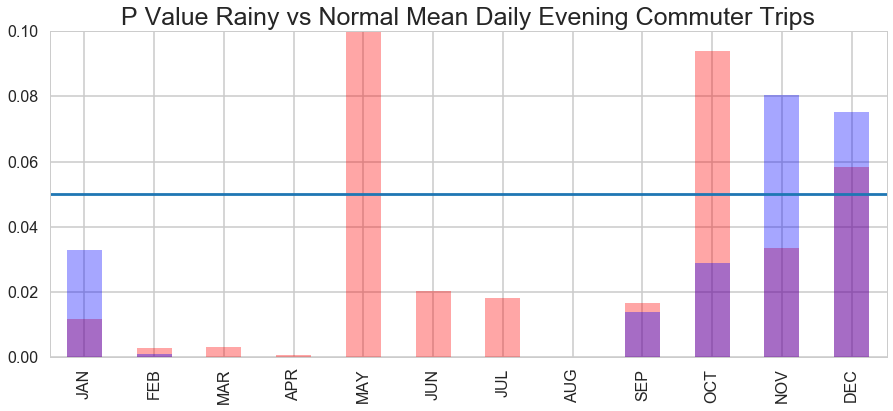

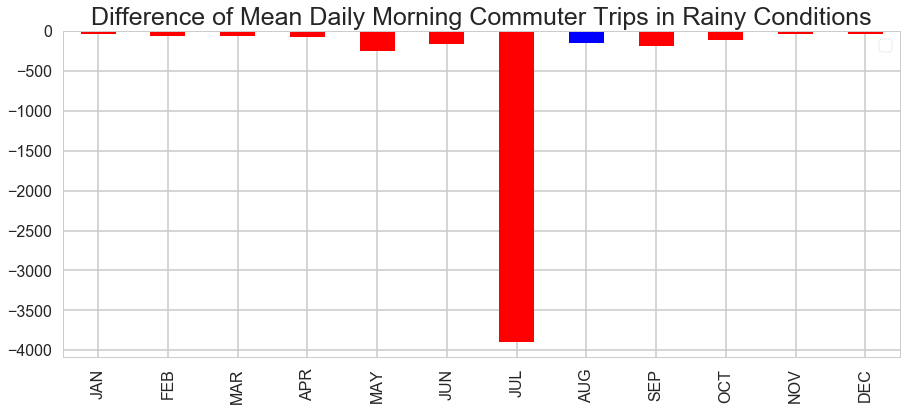

In [44]:
ax = morning_rain_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
morning_rain_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_rain_commute_t_test.index, month_labels)
title = 'P Value Rainy vs Normal Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = morning_rain_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
morning_rain_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(morning_rain_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Morning Commuter Trips in Rainy Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

# Impact of Rain on Evening Commuter Traffic


<div class="alert alert-info">

<p><b>2b. Evening Rainy Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

(71,)
(730,)


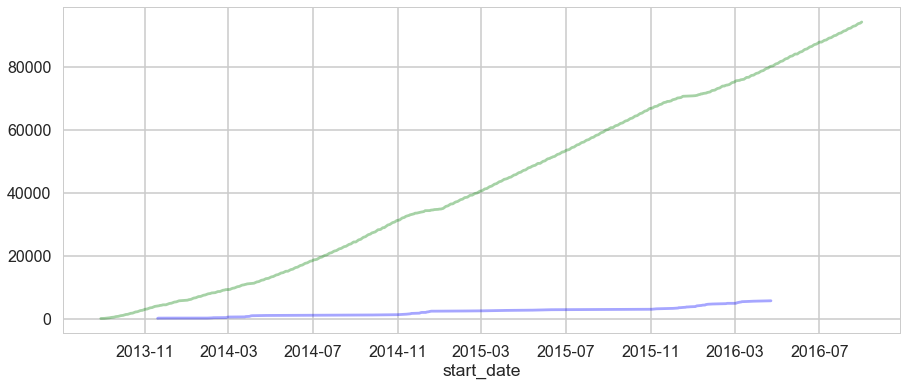

{'diff_of_means': -49.665946363110152,
 'drop_share': -62.478422958554582,
 'normal_dates': 730,
 'normal_mean': 129.15890410958903,
 'rain_dates': 71,
 'rain_mean': 79.492957746478879,
 't_can_reject': True,
 't_p_value': 6.8297675545954294e-19,
 't_score': -9.104085867762814,
 'z_can_reject': True,
 'z_p_value': 4.5967726042413065e-17,
 'z_score': -8.3965782962322049}

In [45]:
# Morning Commutes
RAINY = ss_evening_commutes[ss_evening_commutes.is_rainy_day == True].copy()
RAINY = RAINY.groupby(RAINY.start_date.dt.date)['trip_id'].count()
print(RAINY.shape)

NORM = ss_evening_commutes[ss_evening_commutes.is_rainy_day == False].copy()
NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()
print(NORM.shape)

plt.subplots(figsize=FIG_SIZE)
RAINY.cumsum().plot(color='b', alpha=0.35)
NORM.cumsum().plot(color='g', alpha=0.35)
plt.show()
plt.close()

ranksums_test(RAINY, NORM, a_label='Rain', b_label='Normal')

In [46]:
chunks = []

for month in sorted(ss_evening_commutes.start_date.dt.month.unique()):
    month_data = ss_evening_commutes[ss_evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    RAIN = month_data[month_data.is_rainy_day == True].copy()
    RAIN = RAIN.groupby(RAIN.start_date.dt.date)['trip_id'].count()

    NORM = month_data[month_data.is_rainy_day == False].copy()
    NORM = NORM.groupby(NORM.start_date.dt.date)['trip_id'].count()


        
    R = ranksums_test(RAIN, NORM, a_label='Rain', b_label='Normal', interval_label='dates')
    chunks.append(R)

evening_rainy_commute_t_test = pd.DataFrame(chunks)
evening_rainy_commute_t_test.fillna(0, inplace=True)
# evening_rainy_commute_t_test[(evening_rainy_commute_t_test.z_can_reject == True) | (evening_rainy_commute_t_test.t_can_reject == True)]

evening_rainy_commute_t_test


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


,diff_of_means,drop_share,normal_dates,normal_mean,rain_dates,rain_mean,t_can_reject,t_p_value,t_score,z_can_reject,z_p_value,z_score
0,-31.214035,-36.127355,57,117.614035,10,86.400000,True,3.733365e-02,-2.125688,False,0.050809,-1.953088
1,-53.574074,-75.456442,54,124.574074,8,71.000000,True,7.410755e-04,-3.556425,True,0.000942,-3.307189
2,-61.478571,-89.656250,60,130.050000,14,68.571429,True,9.839172e-08,-5.925245,True,0.000010,-4.416420
3,-46.841808,-50.009048,59,140.508475,6,93.666667,True,6.268037e-05,-4.289767,True,0.003217,-2.946187
4,-56.861538,-71.976631,65,135.861538,1,79.000000,False,0.000000e+00,0.000000,False,0.134645,-1.496034
5,-7.384615,-5.237316,65,148.384615,1,141.000000,False,0.000000e+00,0.000000,False,0.618006,-0.498678
6,-138.552239,-inf,67,138.552239,0,0.000000,False,0.000000e+00,0.000000,False,0.000000,0.000000
7,-150.089552,-inf,67,150.089552,0,0.000000,False,0.000000e+00,0.000000,False,0.000000,0.000000
8,37.156250,23.971774,64,117.843750,1,155.000000,False,0.000000e+00,0.000000,False,0.689340,0.399751
9,-39.176471,-43.529412,68,129.176471,1,90.000000,False,0.000000e+00,0.000000,False,0.482096,-0.702935


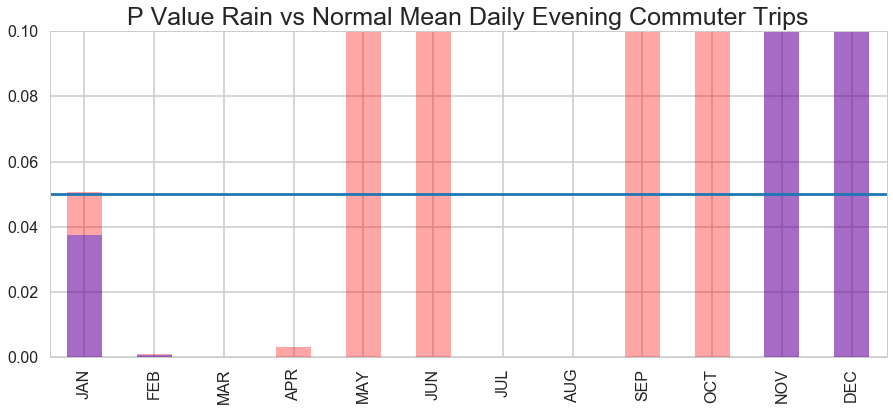

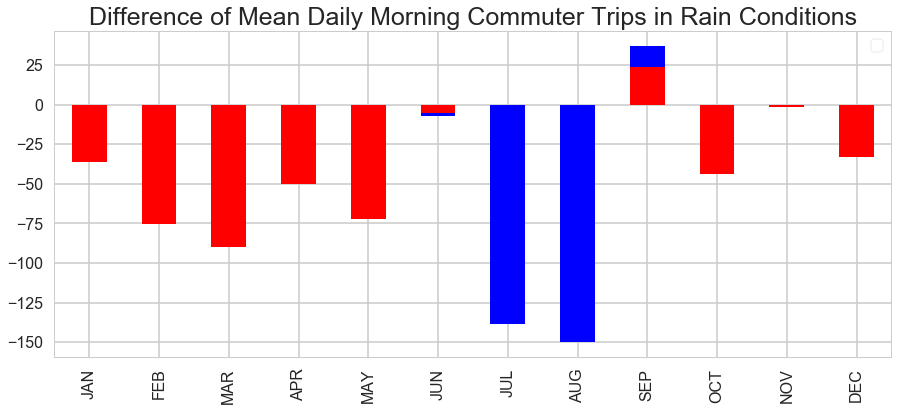

In [47]:
ax = evening_rainy_commute_t_test[['z_p_value']].plot(kind='bar', figsize=FIG_SIZE, color='r', alpha=0.35)
evening_rainy_commute_t_test[['t_p_value']].plot(kind='bar', ax=ax, color='b', alpha=0.35)
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_rainy_commute_t_test.index, month_labels)
title = 'P Value Rain vs Normal Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

ax = evening_rainy_commute_t_test[['diff_of_means']].plot(kind='bar', figsize=FIG_SIZE, color='b')
evening_rainy_commute_t_test[['drop_share']].plot(kind='bar', ax=ax, color='r')
plt.xticks(evening_rainy_commute_t_test.index, month_labels)
title = 'Difference of Mean Daily Morning Commuter Trips in Rain Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)